In [2]:
import pandas as pd
from geopy.geocoders import Photon
from geopy.geocoders import Nominatim
from unidecode import unidecode
import unidecode
import numpy as np
from shapely.geometry import Point, Polygon
import geopandas as gpd
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

from shapely import wkt
import matplotlib.pyplot as plt

This study utilized multiple data sources including migration events data from the National Institute of Migration, support institutions data from both governmental and civil sectors, and criminal incidence data. Additionally, geographic datasets from GIS and customs and border protection were incorporated to map the real-time movements and dynamics of migratory routes across Mexican borders.



In [5]:
dfvalores = pd.read_csv('C:\\Users\\puria\\Documents\\articulo\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\df_valores_rutas.csv')
#dfvalores = pd.read_csv('/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/df_valores_rutas.csv')

In [28]:
inm = pd.read_csv('C:\\Users\\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\3.datos\\1. distribution_infraestructura\\1. Estaciones INM\\inm_gdp.csv')
sc = pd.read_csv('C:\\Users\\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\3.datos\\1. distribution_infraestructura\\2. SC Instituciones\\Facility_Directory.csv')

In [52]:
dfvalores.head()

,nommun,estado,region,id_poligon,codigo_uni,eventos,inm_30km,inm_in_gri,inm_in_est,eventos_ed,...,distancia_metros,distancia_km,max_vul2r1_normalized,max_vul2r2_normalized,max_vul2r3_normalized,max_vul2r4_normalized,inm_30km_adjusted,log_eventos_per_inm_30km,norm_log_eventos_per_inm_30km,latitud
0,"Tapachula, Chiapas",Chiapas,Sur,PG1530,S-PG1530-8,70665.0,2,4,13,223058,...,15537.0,15.537,0.280689,0.440925,0.237571,0.295621,3,10.067136,0.882435,14.904291
1,"Huimanguillo, Tabasco",Tabasco,Sur,PG1456,G-PG1456-1,86684.0,0,0,3,290299,...,325527.0,325.527,1.000000,1.000000,0.877758,0.499600,1,11.370036,1.000000,17.762097
2,"Centro, Tabasco",Tabasco,Sur,PG1495,G-PG1495-6,74160.0,1,1,3,290299,...,224089.0,224.089,0.626950,0.617321,0.549094,0.269827,2,10.520860,0.923376,18.027159
3,"Acayucan, Veracruz",Veracruz,Golfo,PG1378,G-PG1378-4,36446.0,1,1,3,66430,...,448302.0,448.302,NaN,NaN,NaN,NaN,2,9.810495,0.859277,17.948786
4,"Tenosique, Tabasco",Tabasco,Sur,PG1572,G-PG1572-3,39620.0,1,2,3,290299,...,42334.0,42.334,0.437746,0.713052,0.419243,0.248657,2,9.893993,0.866811,17.470713


In [11]:
# Sort the DataFrame by the 'norm_log_eventos_per_inm_30km' column in descending order
dfvalores_sorted = dfvalores.sort_values(by='norm_log_eventos_per_inm_30km', ascending=False)

# Select the first 6 rows and only the columns 'nommun' and 'norm_log_eventos_per_inm_30km'
top_6_dfvalores = dfvalores_sorted[['nommun','region', 'norm_log_eventos_per_inm_30km']].head(60)

# Print the result
print(top_6_dfvalores)


                                         nommun    region  \
1                         Huimanguillo, Tabasco       Sur   
2                               Centro, Tabasco       Sur   
5                            Macuspana, Tabasco       Sur   
7                             Suchiate, Chiapas       Sur   
0                            Tapachula, Chiapas       Sur   
13                            Cardenas, Tabasco       Sur   
4                            Tenosique, Tabasco       Sur   
10                             Arriaga, Chiapas       Sur   
3                            Acayucan, Veracruz     Golfo   
6                      Tijuana, Baja California  Pacifico   
14                            Santa Ana, Sonora  Pacifico   
8                      Piedras Negras, Coahuila    Centro   
16                               Teapa, Tabasco       Sur   
173                  Sayula de Aleman, Veracruz     Golfo   
18                           Tacotalpa, Tabasco       Sur   
21                      

In [12]:
# Function to calculate quintiles
def calculate_quintiles(group):
    return group.quantile([0.2, 0.4, 0.6, 0.8, 1.0])

# Calculate quintiles for 'norm_log_eventos_per_inm_30km' per region
quintiles_per_region = dfvalores.groupby('region')['norm_log_eventos_per_inm_30km'].apply(calculate_quintiles)

# Print the result
print(quintiles_per_region)


region       
Centro    0.2    0.073173
          0.4    0.173281
          0.6    0.315296
          0.8    0.523336
          1.0    0.811783
Golfo     0.2    0.172305
          0.4    0.254527
          0.6    0.363012
          0.8    0.490884
          1.0    0.859277
Pacifico  0.2    0.073173
          0.4    0.240136
          0.6    0.431858
          0.8    0.583546
          1.0    0.833553
Sur       0.2    0.111213
          0.4    0.264492
          0.6    0.430627
          0.8    0.618507
          1.0    1.000000
Name: norm_log_eventos_per_inm_30km, dtype: float64


C:\Users\puria\AppData\Local\Temp\ipykernel_13132\1143960539.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = dfvalores.groupby(['region', 'distancia_bin'])['eventos'].sum().reset_index()
C:\Users\puria\AppData\Local\Temp\ipykernel_13132\1143960539.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_data = binned_data.groupby('distancia_bin_num')['eventos'].mean().reset_index()


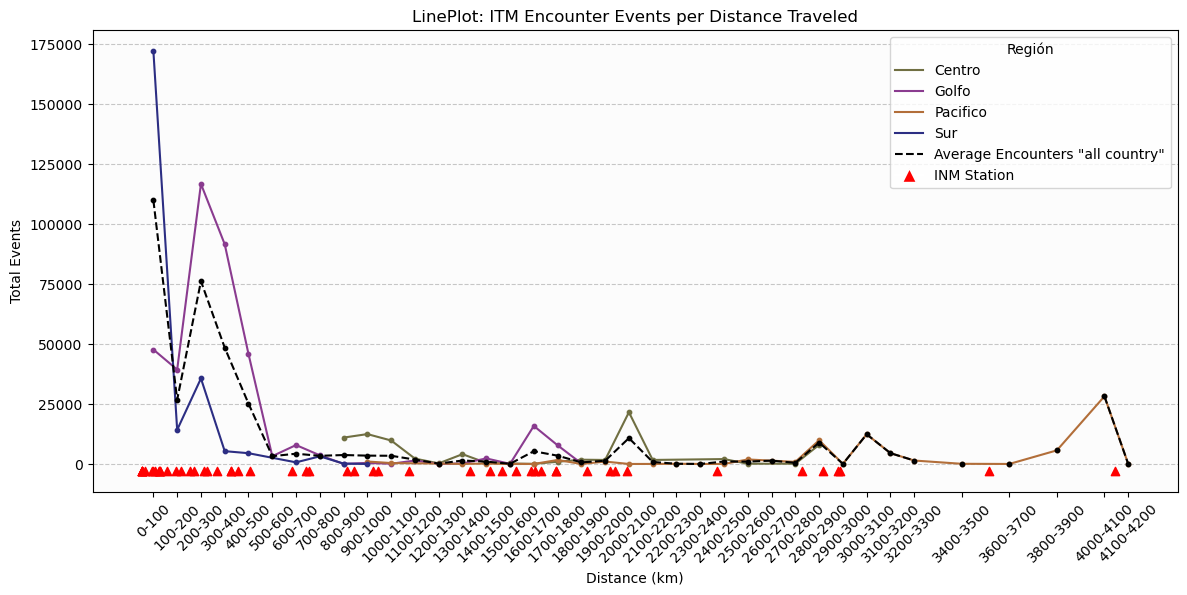

In [109]:
# Definir los colores específicos para cada región
colors = {
    'Golfo': '#8a3b8f',    # Morado
    'Centro': '#706f42',   # Verde oliva
    'Pacifico': '#b26e39', # Naranja
    'Sur': '#2c2e83'       # Azul oscuro
}

# Crear los bins de 100 km
bin_size = 100
bins = np.arange(0, dfvalores['distancia_km'].max() + bin_size, bin_size)
dfvalores['distancia_bin'] = pd.cut(dfvalores['distancia_km'], bins=bins)

# Sumar los eventos por bin y región
binned_data = dfvalores.groupby(['region', 'distancia_bin'])['eventos'].sum().reset_index()

# Filtrar los datos para eliminar los bins con valor 0
binned_data = binned_data[binned_data['eventos'] > 0]

# Crear una columna numérica representativa de los bins para mantener el orden
binned_data['distancia_bin_num'] = binned_data['distancia_bin'].apply(lambda x: x.left + bin_size / 2)

# Crear la figura y los ejes
plt.figure(figsize=(14, 6))

# Graficar cada región con un color diferente
for region in binned_data['region'].unique():
    subset = binned_data[binned_data['region'] == region]
    plt.plot(subset['distancia_bin_num'], subset['eventos'], label=region, color=colors[region], linestyle='-')
    plt.scatter(subset['distancia_bin_num'], subset['eventos'], color=colors[region], s=10, zorder=2)  # Cambiar tamaño del marcador

# Calcular el promedio de eventos por distancia
average_data = binned_data.groupby('distancia_bin_num')['eventos'].mean().reset_index()

# Agregar la línea de promedio al gráfico
plt.plot(average_data['distancia_bin_num'], average_data['eventos'], label='Average Encounters "all country"', color='black', linestyle='--')
plt.scatter(average_data['distancia_bin_num'], average_data['eventos'], color='black', s=10, zorder=2)  # Marcar los puntos promedio

# Añadir títulos y etiquetas
plt.title('LinePlot: ITM Encounter Events per Distance Traveled')
plt.xlabel('Distance (km)')
plt.ylabel('Total Events')
plt.legend(title='Region')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar los ticks del eje x
plt.xticks(ticks=binned_data['distancia_bin_num'].unique(), labels=[f'{int(x.left)}-{int(x.right)}' for x in binned_data['distancia_bin'].unique()], rotation=45)

# Añadir un fondo gris con transparencia
plt.gca().patch.set_facecolor('gray')
plt.gca().patch.set_alpha(0.02)

# Agregar marcadores rojos para las estaciones INM
plt.scatter(inm['distancia_km'], [-3000] * len(inm), color='red', marker='^', zorder=3)  # Mover los marcadores más abajo

# Añadir el marcador 'INM Station' a la leyenda solo si no está ya presente
handles, labels = plt.gca().get_legend_handles_labels()
if 'INM Station' not in labels:
    handles.append(plt.Line2D([0], [0], marker='^', color='w', label='INM Station', markerfacecolor='red', markersize=10))
plt.legend(handles=handles, title='Región')

# Mostrar la gráfica
plt.show()


In [159]:
inm = pd.read_csv('C:\\Users\\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\3.datos\\1. distribution_infraestructura\\1. Estaciones INM\\inm_gdp.csv')

In [83]:
from shapely.ops import nearest_points

In [161]:
# Función para encontrar el punto más cercano en la frontera
def punto_mas_cercano(point, line):
    nearest_point = nearest_points(point, line)[1]
    return nearest_point

# Calcular el punto más cercano en la frontera para cada instituto
gdf_inm['punto_mas_cercano'] = gdf_inm.geometry.apply(lambda x: punto_mas_cercano(x, linea_frontera))

# Convertir a formato WKT para la API (opcional, si lo necesitas)
gdf_inm['punto_mas_cercano_wkt'] = gdf_inm['punto_mas_cercano'].apply(lambda x: x.wkt)
gdf_inm['geometry_wkt'] = gdf_inm['geometry'].apply(lambda x: x.wkt)


NameError: name 'gdf_inm' is not defined

In [111]:
# Supongamos que dfvalores ya está cargado como un DataFrame
#df_institutos = dfvalores

# Verificar si la columna 'geometry' está en formato Point de Shapely, si no, convertirla
if not isinstance(df_institutos['geometry'].iloc[0], Point):
    df_institutos['geometry'] = df_institutos['geometry'].apply(wkt.loads)

# Crear el GeoDataFrame
#gdf_institutos = gpd.GeoDataFrame(df_institutos, geometry=df_institutos['geometry'])

# Asegurarse de que el CRS sea EPSG:4326
#gdf_institutos.set_crs(epsg=4326, inplace=True)


In [14]:
# Obtener la LineString de la frontera
linea_frontera = fronteras_sur.geometry.iloc[0]

# Función para encontrar el punto más cercano en la frontera
def punto_mas_cercano(point, line):
    nearest_point = nearest_points(point, line)[1]
    return nearest_point

# Calcular el punto más cercano en la frontera para cada instituto
gdf_institutos['punto_mas_cercano'] = gdf_institutos.geometry.apply(lambda x: punto_mas_cercano(x, linea_frontera))

# Convertir a formato WKT para la API
gdf_institutos['punto_mas_cercano_wkt'] = gdf_institutos['punto_mas_cercano'].apply(lambda x: x.wkt)
gdf_institutos['geometry_wkt'] = gdf_institutos['geometry'].apply(lambda x: x.wkt)


In [113]:
# Definir tu API key de Google
api_key = 'xxx'



In [94]:
# Función para obtener la distancia desde la API de Google
def obtener_distancia(origen, destino, api_key):
    url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    params = {
        'origins': origen,
        'destinations': destino,
        'mode': 'driving',
        'key': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    if data['status'] == 'OK' and 'rows' in data and 'elements' in data['rows'][0]:
        if data['rows'][0]['elements'][0]['status'] == 'OK':
            distance = data['rows'][0]['elements'][0]['distance']['value']  # en metros
            return distance
        else:
            print(f"Error en la respuesta del elemento: {data['rows'][0]['elements'][0]['status']}")
            return None
    else:
        print(f"Error en la respuesta de la API: {data['status']}")
        return None

# Aplicar la función a cada fila
gdf_inm['distancia_metros'] = gdf_inm.apply(
    lambda row: obtener_distancia(f"{row['punto_mas_cercano'].y},{row['punto_mas_cercano'].x}", 
                                  f"{row['geometry'].y},{row['geometry'].x}", api_key), axis=1)

# Convertir la distancia a kilómetros
gdf_inm['distancia_km'] = gdf_inm['distancia_metros'] / 1000


Error en la respuesta del elemento: ZERO_RESULTS
Error en la respuesta del elemento: ZERO_RESULTS


In [92]:
gdf_institutos.head(2)

,Unnamed: 0.1,Unnamed: 0,nombre,ciudad,estado,region,id_poligon,codigo_uni,eventos,inm_30km,...,eventos_gr,sc_30km,promedio_s,sc_estado,geometry,punto_mas_cercano,punto_mas_cercano_wkt,geometry_wkt,distancia_metros,distancia_km
0,0,0,"Tapachula, Chiapas","Tapachula, Chiapas",Chiapas,Sur,PG1530,S-PG1530-8,70665.0,2,...,113641,67,22.333333,117.0,POINT (-92.26093 14.90429),POINT (-92.18509 14.86677),POINT (-92.1850886242294 14.866768509673829),POINT (-92.2609265 14.9042905),15537.0,15.537
1,1,1,"Huimanguillo, Tabasco","Huimanguillo, Tabasco",Tabasco,Golfo,PG1456,G-PG1456-1,86684.0,0,...,86684,0,0.000000,43.0,POINT (-93.66344 17.76210),POINT (-91.45392 17.25218),POINT (-91.45392127151516 17.252177232324172),POINT (-93.6634408051158 17.7620967),325527.0,325.527


In [26]:
# Guardar el DataFrame en el archivo CSV especificado
#gdf_institutos.to_file('C:\\Users\\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\df_valores_rutas.shp', index=False)


### Literary Review and Background: Case Study (Mexico MTI)


### Phase 1 A Comprehensive reconstruction on the components that configure the irregular migration routes within Mexico’s migration corridor: Route Identification.

[Metodologias de extraccion, grid, rutas combinadas, objetos de analisis.]

### Phase 2 Route Analysis Metrics: Vulnerabilities and cost.

Métrica de Vulnerabilidad 1

La Métrica de Vulnerabilidad 1 en este estudio se enfoca en evaluar la cobertura institucional en relación con la migración irregular. Esta métrica compara el número de eventos de detención de migrantes (eventos de encuentro) en cada municipio con la cantidad de instituciones disponibles en la misma área, como estaciones del Instituto Nacional de Migración (GOB) y Centros de Atención Social (SC). El objetivo es determinar si las instituciones están adecuadamente distribuidas para manejar y apoyar a los migrantes a lo largo de sus rutas, especialmente en áreas de alta incidencia. Esto permite identificar zonas de alta vulnerabilidad donde la capacidad institucional es insuficiente para el volumen de eventos de migración registrados, proporcionando una base para estrategias de intervención más efectivas y dirigidas.



Para aplicar la transformación logarítmica a las métricas que has creado, puedes usar la función np.log1p de NumPy, que es adecuada para este propósito porque calcula el logaritmo natural de 
1+x, lo cual es útil para manejar ceros y datos de conteo.

Normalización: Para que el índice esté en una escala de 0 a 1 y sea comparativo entre municipios, se puede normalizar el ICI ajustado

In [56]:
mun_shp = gpd.read_file("C:\\Users\\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\Metodo_1\\areas\\municipiosrisk1.shp")


In [57]:
mun_shp.head()


,nommun,cvemun,nomedo,area,R1,R2,R3,R4,R4pt,geometry
0,"Aguascalientes, Aguascalientes",1001,Aguascalientes,1168.762384,0.360084,0.372695,0.117251,0.662296,0.000458,"POLYGON ((-11370403.590 2520317.662, -11368883..."
1,"Asientos, Aguascalientes",1002,Aguascalientes,547.762077,0.019696,0.011381,0.017855,0.745202,0.000515,"POLYGON ((-11368305.122 2546014.561, -11367916..."
2,"Calvillo, Aguascalientes",1003,Aguascalientes,931.300088,0.019349,0.013107,0.013835,0.708078,0.000489,"POLYGON ((-11444356.824 2510725.426, -11444212..."
3,"Cosio, Aguascalientes",1004,Aguascalientes,128.907513,0.012770,0.010345,0.012474,0.704691,0.000487,"POLYGON ((-11387740.145 2566722.259, -11387556..."
4,"El Llano, Aguascalientes",1010,Aguascalientes,500.861359,0.012770,0.012417,0.011113,0.710027,0.000491,"POLYGON ((-11365483.996 2514328.561, -11364488..."


In [22]:
# Cambiar el nombre de una columna en el DataFrame original
mun_shp.rename(columns={'municipio_': 'nommun', 'cvemunic': 'cvemun'}, inplace=True)

In [147]:
dfvalores['inm_30km_adjusted'] = dfvalores['inm_30km'] + 1  # Añadir 1 para suavizar
#dfvalores['sc_30km_adjusted'] = dfvalores['sc_30km'] + 1

#dfvalores['eventos_per_inm_30km'] = np.log1p(dfvalores['eventos']) / dfvalores['inm_30km']

# Recalcular los ratios con los valores ajustados

dfvalores['log_eventos_per_inm_30km'] = np.log1p(dfvalores['eventos'] / dfvalores['inm_30km_adjusted'])

# Normalización Min-Max
dfvalores['norm_log_eventos_per_inm_30km'] = (dfvalores['log_eventos_per_inm_30km'] - dfvalores['log_eventos_per_inm_30km'].min()) / (dfvalores['log_eventos_per_inm_30km'].max() - dfvalores['log_eventos_per_inm_30km'].min())


In [26]:
from shapely import wkt
# Crear una función para extraer la latitud
def extract_latitude(point):
    return point.y

# Asegúrate de que la columna 'geometry' está en el formato de shapely Point
dfvalores['geometry'] = dfvalores['geometry'].apply(wkt.loads)

# Crear una nueva columna para la latitud
dfvalores['latitud'] = dfvalores['geometry'].apply(extract_latitude)



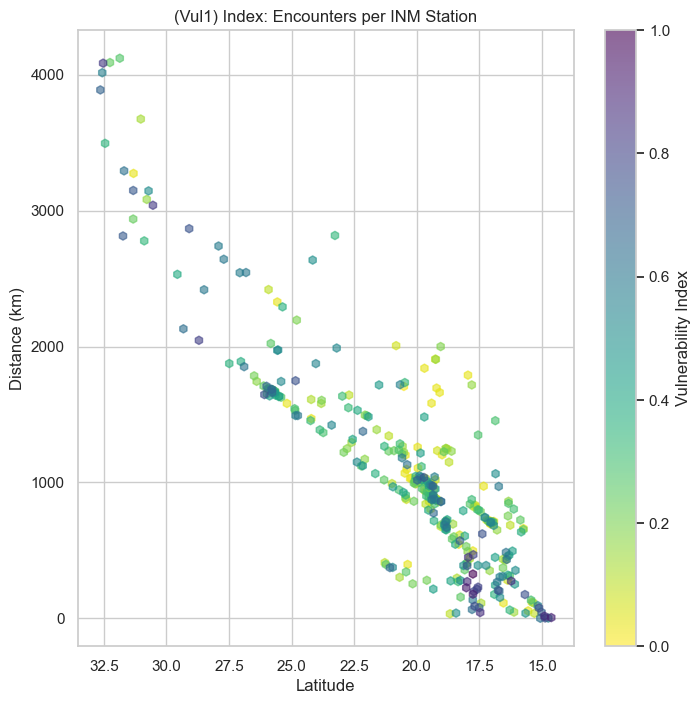

In [182]:
# Ordenar el DataFrame por la columna 'norm_log_eventos_per_inm_30km' en orden ascendente
dfvalores_sorted = dfvalores.sort_values(by='norm_log_eventos_per_inm_30km')

# Crear la figura y el gráfico de dispersión con marcadores hexagonales
plt.figure(figsize=(8, 8))

sc = plt.scatter(dfvalores_sorted['latitud'], dfvalores_sorted['distancia_km'], c=dfvalores_sorted['norm_log_eventos_per_inm_30km'], cmap='viridis_r', marker='h', alpha=0.6)

# Añadir la barra de colores
plt.colorbar(sc, label='Vulnerability Index')

# Invertir el eje x (descomentar si es necesario)
plt.gca().invert_xaxis()

plt.title('(Vul1) Index: Encounters per INM Station')
plt.xlabel('Latitude')
plt.ylabel('Distance (km)')

# Mostrar la gráfica
plt.show()

La métrica busca capturar la relación entre la cantidad de eventos de migrantes detectados y la capacidad institucional disponible para manejar esos eventos. Aquí detallo los aspectos clave de la métrica hasta el momento:

Definición Original de ICI:
Inicialmente, el ICI se definió como el número de eventos registrados por cada institución en un radio de 30 km (INM y SC), proporcionando un ratio directo que reflejaba la presión sobre los recursos institucionales disponibles.

Ajustes Realizados:
Transformación Logarítmica:
Propósito: Para manejar mejor la distribución asimétrica de los datos y evitar la influencia desproporcionada de valores extremos en la métrica.
Método: Se aplicó 
log
⁡
(
1
+
�
)
log(1+x) a los ratios para suavizar la variación y estabilizar la varianza en los datos.
Normalización Min-Max:
Propósito: Escalar los valores transformados a una escala de 0 a 1, facilitando la comparación entre municipios.
Método: Se normalizaron los valores ajustados de modo que el valor mínimo corresponde a 0 y el máximo a 1.
Corrección de Laplace:
Para abordar el caso de municipios sin instituciones, se añadió 1 a los conteos de instituciones (suavización de Laplace), permitiendo calcular ratios incluso en ausencia de instituciones y evitando divisiones por cero.

Interpretación de la Métrica de Vulnerabilidad:
Valores Cercanos a 1: Indican una alta vulnerabilidad, reflejando una mayor cantidad de eventos por institución después de los ajustes. Esto sugiere que las instituciones en estos municipios están potencialmente sobrecargadas o insuficientes para gestionar el volumen de eventos.
Valores Cercanos a 0: Indican una menor vulnerabilidad, sugiriendo que la relación entre eventos e instituciones es más manejable.
Valor de 0 en la Métrica Ajustada: Específicamente señala a municipios sin instituciones disponibles, destacando una situación de alta vulnerabilidad, ya que no hay capacidad institucional registrada para atender ningún evento.
Uso y Aplicaciones:
Esta métrica puede ser utilizada por autoridades y organizaciones para:

Identificar áreas críticas que requieren atención inmediata o reasignación de recursos.
Planificar de manera más efectiva la distribución de recursos y la implementación de políticas.
Monitorear y evaluar el impacto de intervenciones y mejoras en la infraestructura y servicios a lo largo del tiempo.
La vulnerabilidad, tal como se ha modelado hasta ahora, proporciona una herramienta cuantitativa para evaluar y comparar la capacidad de respuesta institucional frente a los flujos migratorios, permitiendo así una gestión más informada y focalizada de los recursos en el contexto de la migración irregular.

### Vulnerabilidad 2

Exposición a Zona de Riesgo es una métrica diseñada para cuantificar y visualizar la exposición de las rutas migratorias a zonas de alto riesgo, considerando tanto la distancia de las rutas a estas zonas como la capacidad institucional disponible para mitigar dicho riesgo.

In [155]:
# Establecer la opción para mostrar todas las columnas
pd.set_option('display.max_columns', None)

In [334]:
#segmentos.to_csv('C:\\Users\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\procesamiento de rutas\\arcos\\segmentos\\segmentos.csv')

In [118]:
#segmentos = gpd.read_file('/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/procesamiento de rutas/arcos/segmentos/segmentos.shp').to_crs(epsg=4485)
segmentos = pd.read_csv('C:\\Users\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\procesamiento de rutas\\arcos\\segmentos\\segmentos.csv')

In [58]:
mun_shp = gpd.read_file('C:\\Users\\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\areas\\municipiosrisk1.shp')

In [165]:
#dfvalores = pd.read_csv('C:\\Users\\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\df_valores_rutas.csv')
#dfvalores.to_csv('C:\\Users\\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\df_valores_rutas.csv')

In [134]:
# Paso 1: Agrupar por 'nommun' y encontrar el valor máximo de 'vul2r1_normalized' para cada grupo
max_vul2r1 = final_df.groupby('nommun')['vul2_R1_normalized'].max().reset_index()
max_vul2r2 = final_df.groupby('nommun')['vul2_R2_normalized'].max().reset_index()
max_vul2r3 = final_df.groupby('nommun')['vul2_R3_normalized'].max().reset_index()
max_vul2r4 = final_df.groupby('nommun')['vul2_R4_normalized'].max().reset_index()


# Paso 2: Renombrar la columna para que sea más claro
max_vul2r1 = max_vul2r1.rename(columns={'vul2_R1_normalized': 'max_vul2r1_normalized'})
max_vul2r2 = max_vul2r2.rename(columns={'vul2_R2_normalized': 'max_vul2r2_normalized'})
max_vul2r3 = max_vul2r3.rename(columns={'vul2_R3_normalized': 'max_vul2r3_normalized'})
max_vul2r4 = max_vul2r4.rename(columns={'vul2_R4_normalized': 'max_vul2r4_normalized'})


In [180]:
dfvalores.head()

,Unnamed: 0.1,Unnamed: 0,nommun,estado,region,id_poligon,codigo_uni,eventos,inm_30km,inm_in_gri,inm_in_est,eventos_ed,eventos_gr,sc_30km,promedio_s,sc_estado,geometry,distancia_metros,distancia_km,max_vul2r1_normalized,max_vul2r2_normalized,max_vul2r3_normalized,max_vul2r4_normalized,inm_30km_adjusted,log_eventos_per_inm_30km,norm_log_eventos_per_inm_30km,latitud
0,0,0,"Tapachula, Chiapas",Chiapas,Sur,PG1530,S-PG1530-8,70665.0,2,4,13,223058,113641,67,22.333333,117.0,POINT (-92.26093 14.90429),15537.0,15.537,0.280689,0.440925,0.237571,0.295621,3,10.067136,0.882435,14.904291
1,1,1,"Huimanguillo, Tabasco",Tabasco,Sur,PG1456,G-PG1456-1,86684.0,0,0,3,290299,86684,0,0.000000,43.0,POINT (-93.66344 17.76210),325527.0,325.527,1.000000,1.000000,0.877758,0.499600,1,11.370036,1.000000,17.762097
2,2,2,"Centro, Tabasco",Tabasco,Sur,PG1495,G-PG1495-6,74160.0,1,1,3,290299,105212,7,2.833333,43.0,POINT (-92.77479 18.02716),224089.0,224.089,0.626950,0.617321,0.549094,0.269827,2,10.520860,0.923376,18.027159
3,3,3,"Acayucan, Veracruz",Veracruz,Golfo,PG1378,G-PG1378-4,36446.0,1,1,3,66430,45773,25,15.000000,54.0,POINT (-94.91458 17.94879),448302.0,448.302,NaN,NaN,NaN,NaN,2,9.810495,0.859277,17.948786
4,4,4,"Tenosique, Tabasco",Tabasco,Sur,PG1572,G-PG1572-3,39620.0,1,2,3,290299,53905,34,19.333333,43.0,POINT (-91.42202 17.47071),42334.0,42.334,0.437746,0.713052,0.419243,0.248657,2,9.893993,0.866811,17.470713


In [141]:
dfvalores = dfvalores.merge(max_vul2r1, on='nommun', how='left')

In [142]:
dfvalores = dfvalores.merge(max_vul2r2, on='nommun', how='left')


In [143]:
dfvalores = dfvalores.merge(max_vul2r3, on='nommun', how='left')


In [144]:
dfvalores = dfvalores.merge(max_vul2r4, on='nommun', how='left')

C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

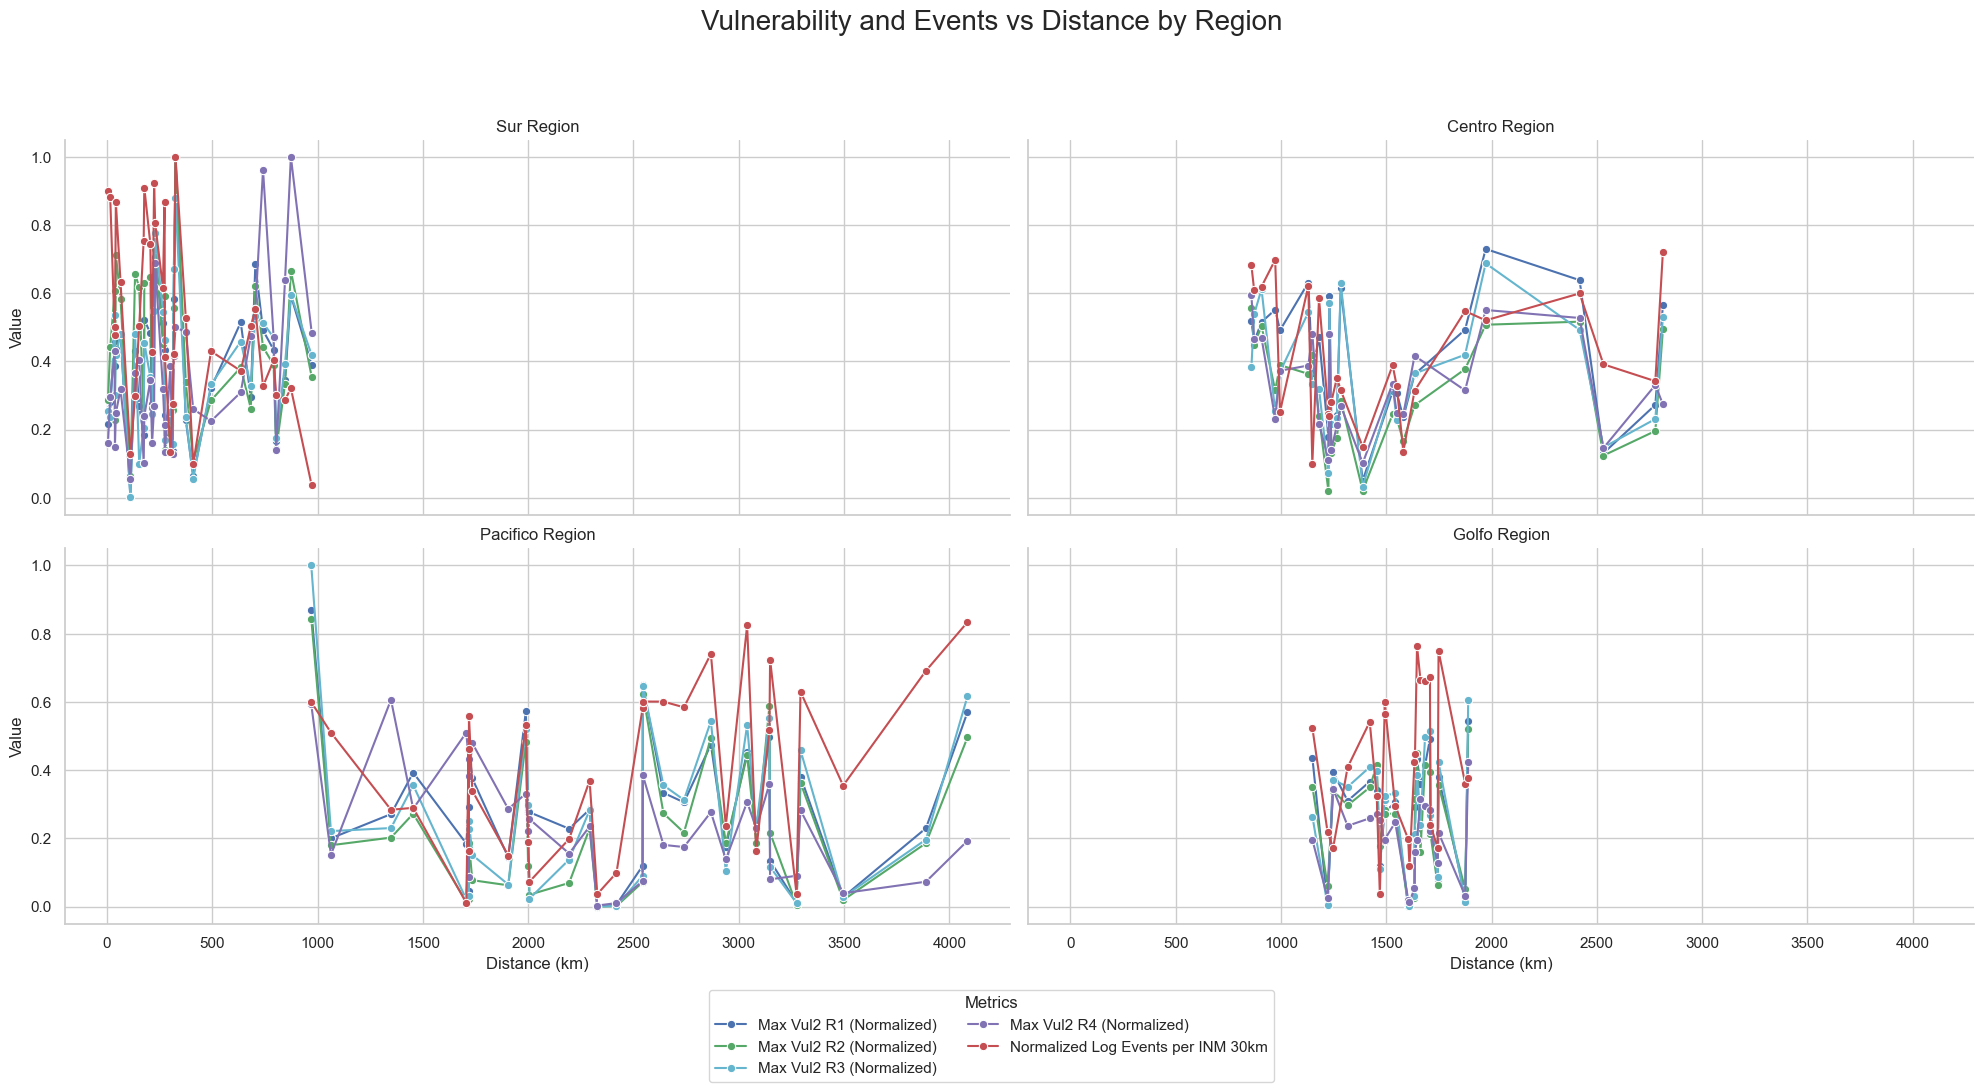

In [166]:
# Convert infinite values to NaN
dfvalores.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar filas con valores NaN en 'distancia_km', 'max_vul2r1_normalized', 'max_vul2r2_normalized', 
# 'max_vul2r3_normalized', 'max_vul2r4_normalized', 'region', y 'norm_log_eventos_per_inm_30km'
dfvalores_cleaned = dfvalores.dropna(subset=['distancia_km', 'max_vul2r1_normalized', 'max_vul2r2_normalized', 'max_vul2r3_normalized', 'max_vul2r4_normalized', 'region', 'norm_log_eventos_per_inm_30km'])

# Ordenar el DataFrame por 'distancia_km' de menor a mayor
dfvalores_sorted = dfvalores_cleaned.sort_values(by='distancia_km')

# Configuración de Seaborn
sns.set(style="whitegrid")

# Crear el grid de subplots
g = sns.FacetGrid(dfvalores_sorted, col='region', col_wrap=2, sharex=True, sharey=True, height=5, aspect=2)

# Función para mapear las líneas en cada subplot con diferentes colores
def plot_multiple_lines(data, **kwargs):
    sns.lineplot(x='distancia_km', y='max_vul2r1_normalized', data=data, marker='o', label='Max Vul2 R1 (Normalized)', color='b')
    sns.lineplot(x='distancia_km', y='max_vul2r2_normalized', data=data, marker='o', label='Max Vul2 R2 (Normalized)', color='g')
    sns.lineplot(x='distancia_km', y='max_vul2r3_normalized', data=data, marker='o', label='Max Vul2 R3 (Normalized)', color='c')
    sns.lineplot(x='distancia_km', y='max_vul2r4_normalized', data=data, marker='o', label='Max Vul2 R4 (Normalized)', color='m')
    sns.lineplot(x='distancia_km', y='norm_log_eventos_per_inm_30km', data=data, marker='o', label='Normalized Log Events per INM 30km', color='r')

# Mapear el gráfico de líneas a cada subplot
g.map_dataframe(plot_multiple_lines)

# Añadir títulos y etiquetas
g.set_axis_labels('Distance (km)', 'Value')
g.set_titles(col_template='{col_name} Region')

# Ajustar el layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Vulnerability and Events vs Distance by Region', fontsize=20)

# Añadir leyenda debajo de los gráficos
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='lower center', ncol=2, title='Metrics', bbox_to_anchor=(0.5, -0.1))

# Mostrar la gráfica
plt.show()


 ### arreglar distancias para volver a calcular

## paso a a paso calculo vul 2
esto se hace para cada riesgo o conjunto de riesgos:

### 1) calculamos la vul inicial

In [336]:
# Calcular vul2 inicial para nodos de origen
segmentos['vul2_ori'] = np.where(segmentos['tipo_nodo'] == 'origen',
                                 segmentos['R1'] * segmentos['eventos'] / (segmentos['sc_30km'] + 1), np.nan)

# Verificar los resultados
#print(segmentos[['arc', 'nommun', 'dist_ori', 'dist_des', 'tipo_nodo', 'vul2_ori']].head(20))

segmentos['vul2_des'] = np.where(segmentos['tipo_nodo'] == 'destino',
                                 segmentos['R1'] * segmentos['eventos'] / (segmentos['sc_30km'] + 1), np.nan)

### 2) calculamos la vul acum_origen esla vulnerabilidad acumulada de los nodos de origen

In [337]:
def calcular_acum_origen(segmentos):
    segmentos['acum_origen'] = np.nan

    # Calcular ALL_ARCS_TOTAL_DIST
    all_arcs_total_dist = segmentos.groupby('arc')['dis_tot'].max().sum()

    # Contar el número de ciudades intersectantes por nodo de origen
    num_intersectantes_por_nodo = segmentos[segmentos['tipo_nodo'] == 'intersectante'].groupby('arc').size()

    for i, fila in segmentos[segmentos['tipo_nodo'] == 'intersectante'].iterrows():
        arc = fila['arc']
        num_intersectantes = num_intersectantes_por_nodo[arc]

        if fila['dist_ori'] < fila['dis_tot'] / 2:
            # Caso 1: dp,i < darc/2
            ajuste_vul = ((fila['R1'] * fila['dist_ori'] * (all_arcs_total_dist / fila['dis_tot']) / fila['dis_tot'] - fila['dist_ori']) / fila['sc_30km']) * 100 / num_intersectantes
        elif fila['dist_ori'] == fila['dis_tot'] / 2:
            # Caso 2: dp,i == darc/2
            ajuste_vul = 0.5 * ((fila['R1'] * fila['dist_ori'] * (all_arcs_total_dist / fila['dis_tot']) / fila['dis_tot'] - fila['dist_ori']) / fila['sc_30km']) * 100 / num_intersectantes
        else:
            # Caso 3: dp,i > darc/2, no se hacen más cálculos
            ajuste_vul = np.nan
        
        segmentos.at[i, 'acum_origen'] = ajuste_vul

    return segmentos

# Aplicar la función al dataframe segmentos
segmentos = calcular_acum_origen(segmentos)

# Verificar los resultados
#print(segmentos[['arc', 'nommun', 'dist_ori', 'dist_des', 'tipo_nodo', 'vul2_ori', 'acum_origen']].head(20))



### 3) calculamos la vul 2 multiplicando la vulnerabilidad acumulada de los nodos de origen por la vul inicial origen

In [338]:
# Suponiendo que segmentos ya tiene las columnas 'tipo_nodo', 'dist_ori', 'dis_tot', 'R1', 'sc_30km', 'acum_origen', 'vul2_ori'

# Calcular vul2 para nodos de origen multiplicando por acum_origen de las filas intersectantes
def calcular_vul2(segmentos):
    # Inicializar la columna 'vul2' con NaN
    segmentos['vul2'] = np.nan
    
    # Iterar sobre las filas de nodos origen
    for i, nodo in segmentos[segmentos['tipo_nodo'] == 'origen'].iterrows():
        # Empezar con vul2_ori como base
        vul2_valor = nodo['vul2_ori']
        
        # Considerar las ciudades intersectantes hacia abajo que tienen el mismo 'arc'
        ciudades_intersectantes = segmentos[(segmentos['arc'] == nodo['arc']) & (segmentos.index > i)]
        
        for j, ciudad in ciudades_intersectantes.iterrows():
            if not np.isnan(ciudad['acum_origen']):
                vul2_valor *= ciudad['acum_origen']
        
        # Asignar el valor calculado a la columna 'vul2' en la fila del nodo origen
        segmentos.at[i, 'vul2r1'] = vul2_valor
    
    return segmentos

# Aplicar la función al dataframe segmentos
segmentos = calcular_vul2(segmentos)

# Verificar los resultados
#print(segmentos[['arc', 'nommun', 'dist_ori', 'dist_des', 'tipo_nodo', 'vul2_ori', 'acum_origen', 'vul2']].head(20))


### 4) calculamos la vul acum_des esla vulnerabilidad acumulada de los nodos de destino

In [339]:
def calcular_acum_destino(segmentos):
    segmentos['acum_des'] = np.nan

    # Calcular ALL_ARCS_TOTAL_DIST
    all_arcs_total_dist = segmentos.groupby('arc')['dis_tot'].max().sum()

    # Contar el número de ciudades intersectantes por nodo de destino
    num_intersectantes_por_nodo = segmentos[segmentos['tipo_nodo'] == 'intersectante'].groupby('arc').size()

    for i, fila in segmentos[segmentos['tipo_nodo'] == 'intersectante'].iterrows():
        arc = fila['arc']
        num_intersectantes = num_intersectantes_por_nodo[arc]

        if fila['dist_des'] < fila['dis_tot'] / 2:
            # Caso 1: dp,i < darc/2
            ajuste_vul = ((fila['R1'] * fila['dist_des'] * (all_arcs_total_dist / fila['dis_tot']) / fila['dis_tot'] - fila['dist_des']) / fila['sc_30km']) * 100 / num_intersectantes
        elif fila['dist_des'] == fila['dis_tot'] / 2:
            # Caso 2: dp,i == darc/2
            ajuste_vul = 0.5 * ((fila['R1'] * fila['dist_des'] * (all_arcs_total_dist / fila['dis_tot']) / fila['dis_tot'] - fila['dist_des']) / fila['sc_30km']) * 100 / num_intersectantes
        else:
            # Caso 3: dp,i > darc/2, no se hacen más cálculos
            ajuste_vul = np.nan
        
        segmentos.at[i, 'acum_des'] = ajuste_vul

    return segmentos

# Aplicar la función al dataframe segmentos
segmentos = calcular_acum_destino(segmentos)

# Verificar los resultados
#print(segmentos[['arc', 'nommun', 'dist_ori', 'dist_des', 'tipo_nodo', 'vul2_des', 'acum_des']].head(20))


### 5) calculamos la vul 2 multiplicando la vulnerabilidad acumulada de los nodos de destino por la vul inicial destino

In [156]:
def calcular_vul2(segmentos):
    # Iterar sobre las filas de nodos destino
    for i, nodo in segmentos[segmentos['tipo_nodo'] == 'destino'].iterrows():
        # Empezar con vul2_des como base
        vul2_valor = nodo['vul2_des']
        
        # Considerar las ciudades intersectantes hacia arriba que tienen el mismo 'arc'
        ciudades_intersectantes = segmentos[(segmentos['arc'] == nodo['arc']) & (segmentos.index < i)]
        
        for j, ciudad in ciudades_intersectantes.iterrows():
            if not np.isnan(ciudad['acum_des']):
                vul2_valor *= ciudad['acum_des']
        
        # Asignar el valor calculado a la columna 'vul2' en la fila del nodo destino
        segmentos.at[i, 'vul2r1'] = vul2_valor
    
    return segmentos

# Aplicar la función al dataframe segmentos
#segmentos = calcular_vul2(segmentos)

# Verificar los resultados
#print(segmentos[['arc', 'nommun', 'dist_ori', 'dist_des', 'tipo_nodo', 'vul2_ori', 'vul2_des', 'acum_origen', 'acum_des', 'vul2r1']].head(20))


#### normalizamos 0-1 usando log des standar para tratar valores extremos

In [392]:
# Función para la normalización logarítmica
def log_normalize(series):
    # Aplicar el logaritmo natural a los valores no nulos y no negativos
    series_nonan = series.dropna()
    series_log = np.log(series_nonan + 1)  # Sumar 1 para evitar log(0)
    
    # Normalizar los valores logarítmicos entre 0 y 1
    min_val = series_log.min()
    max_val = series_log.max()
    series_log_normalized = (series_log - min_val) / (max_val - min_val)
    
    # Combinar los valores normalizados con los valores NaN originales
    series_normalized = series.copy()
    series_normalized.loc[series_nonan.index] = series_log_normalized
    
    return series_normalized

# Aplicar la función de normalización logarítmica a la columna 'vul2r1'
segmentos['vul2r1_normalized'] = log_normalize(segmentos['vul2r1'])

# Verificar los resultados
print(segmentos[['nommun', 'vul2r1', 'vul2r1_normalized']].head(20))



                        nommun        vul2r1  vul2r1_normalized
0            Suchiate, Chiapas     90.293170           0.207359
1    Frontera Hidalgo, Chiapas           NaN                NaN
2           Tapachula, Chiapas     54.293104           0.184325
3           Tapachula, Chiapas    224.675268           0.248932
4          Acacoyagua, Chiapas           NaN                NaN
5          Acapetahua, Chiapas           NaN                NaN
6           Escuintla, Chiapas           NaN                NaN
7           Huehuetan, Chiapas           NaN                NaN
8             Huixtla, Chiapas           NaN                NaN
9            Tuzantan, Chiapas           NaN                NaN
10  Villa Comaltitlan, Chiapas           NaN                NaN
11         Mapastepec, Chiapas   4478.626576           0.386198
12         Mapastepec, Chiapas      0.205299           0.008578
13         Pijijiapan, Chiapas     77.993368           0.200711
14         Pijijiapan, Chiapas     77.99

In [393]:
#segmentos.to_file('/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/procesamiento de rutas/arcos/segmentos/segmentos.shp')
#dfvalores.to_csv('C:\\Users\\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\df_valores_rutas.csv')
#segmentos.to_csv('C:\\Users\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\procesamiento de rutas\\arcos\\segmentos\\segmentos.csv')
#segmentos.to_file('C:\\Users\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\procesamiento de rutas\\arcos\\segmentos\\segmentos1.shp')

In [109]:
dfvalores = pd.read_csv('C:\\Users\\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\df_valores_rutas.csv')


In [153]:
dfvalores.head(2)

,Unnamed: 0.1,Unnamed: 0,nommun,estado,region,id_poligon,codigo_uni,eventos,inm_30km,inm_in_gri,...,distancia_metros,distancia_km,max_vul2r1_normalized,max_vul2r2_normalized,max_vul2r3_normalized,max_vul2r4_normalized,inm_30km_adjusted,log_eventos_per_inm_30km,norm_log_eventos_per_inm_30km,latitud
0,0,0,"Tapachula, Chiapas",Chiapas,Sur,PG1530,S-PG1530-8,70665.0,2,4,...,15537.0,15.537,0.280689,0.440925,0.237571,0.295621,3,10.067136,0.882435,14.904291
1,1,1,"Huimanguillo, Tabasco",Tabasco,Sur,PG1456,G-PG1456-1,86684.0,0,0,...,325527.0,325.527,1.000000,1.000000,0.877758,0.499600,1,11.370036,1.000000,17.762097


## hacer el merge con df_valores

In [151]:

# Convertir la columna 'geometry' a objetos Point
def convert_to_point(geometry_str):
    try:
        # Extraer las coordenadas de la cadena y crear un objeto Point
        coords = geometry_str.replace('POINT (', '').replace(')', '').split()
        return Point(float(coords[0]), float(coords[1]))
    except Exception as e:
        print(f"Error converting geometry: {e}")
        return None

# Aplicar la conversión solo a las filas que son cadenas
dfvalores['geometry'] = dfvalores['geometry'].apply(lambda x: convert_to_point(x) if isinstance(x, str) else x)

# Convertir el DataFrame a GeoDataFrame
dfvalores = gpd.GeoDataFrame(dfvalores, geometry='geometry', crs='EPSG:4326')

# Extraer la latitud de la columna geometry y crear una nueva columna llamada latitud
dfvalores['latitud'] = dfvalores['geometry'].apply(lambda point: point.y)

# Verificar los resultados
print(dfvalores[['geometry', 'latitud']].head(20))



                       geometry    latitud
0    POINT (-92.26093 14.90429)  14.904291
1    POINT (-93.66344 17.76210)  17.762097
2    POINT (-92.77479 18.02716)  18.027159
3    POINT (-94.91458 17.94879)  17.948786
4    POINT (-91.42202 17.47071)  17.470713
5    POINT (-92.59611 17.76092)  17.760922
6   POINT (-117.01953 32.53174)  32.531740
7    POINT (-92.24196 14.63217)  14.632174
8   POINT (-100.51484 28.70417)  28.704172
9    POINT (-92.50400 15.12213)  15.122125
10   POINT (-93.90084 16.23447)  16.234471
11   POINT (-92.42867 15.02172)  15.021716
12   POINT (-93.11596 16.75380)  16.753801
13   POINT (-93.37533 17.99088)  17.990878
14  POINT (-111.11849 30.54109)  30.541092
15   POINT (-93.20802 15.68500)  15.684999
16   POINT (-92.94805 17.55665)  17.556653
17  POINT (-110.96922 29.09482)  29.094821
18   POINT (-92.82534 17.59522)  17.595220
19   POINT (-91.98092 17.50919)  17.509188


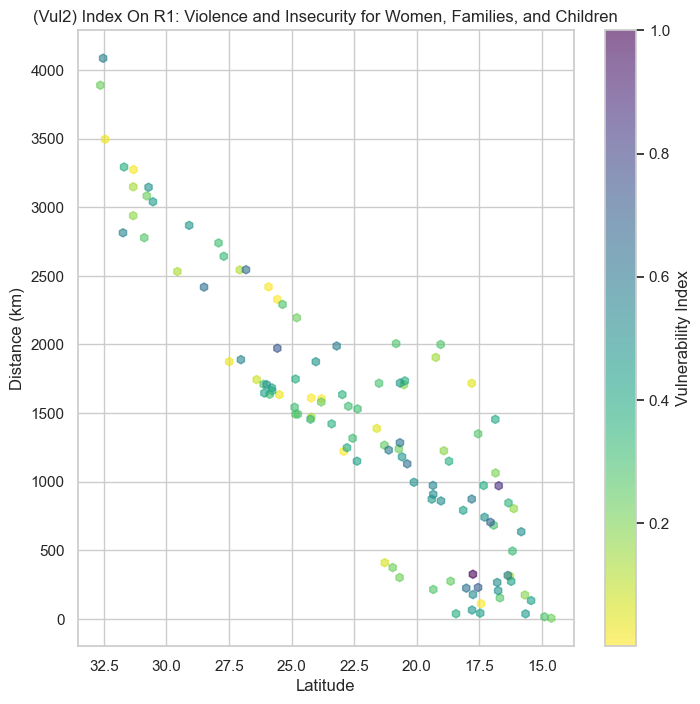

In [152]:
# Ordenar el DataFrame por la columna 'norm_log_eventos_per_inm_30km' en orden ascendente
dfvalores_sorted = dfvalores.sort_values(by='max_vul2r1_normalized')

# Crear la figura y el gráfico de dispersión con marcadores hexagonales
plt.figure(figsize=(8, 8))

sc = plt.scatter(dfvalores_sorted['latitud'], dfvalores_sorted['distancia_km'], c=dfvalores_sorted['max_vul2r1_normalized'], cmap='viridis_r', marker='h', alpha=0.6)

# Añadir la barra de colores
plt.colorbar(sc, label='Vulnerability Index')

# Invertir el eje x (descomentar si es necesario)
plt.gca().invert_xaxis()

plt.title('(Vul2) Index On R1: Violence and Insecurity for Women, Families, and Children')
plt.xlabel('Latitude')
plt.ylabel('Distance (km)')

# Mostrar la gráfica
plt.show()


## para el dataframe segmentos, calculamos el df final de cada vul2 con el siguiente codigo

In [114]:
# Define a function to calculate vul2_ori and vul2_des for a given risk type
def initialize_vul2(segmentos, risk_type):
    vul2_ori_col = f'vul2_ori_{risk_type}'
    vul2_des_col = f'vul2_des_{risk_type}'
    
    segmentos[vul2_ori_col] = np.where(segmentos['tipo_nodo'] == 'origen',
                                       segmentos[risk_type] * segmentos['eventos'] / (segmentos['sc_30km'] + 1), np.nan)
    
    segmentos[vul2_des_col] = np.where(segmentos['tipo_nodo'] == 'destino',
                                       segmentos[risk_type] * segmentos['eventos'] / (segmentos['sc_30km'] + 1), np.nan)
    return segmentos

# Define a function to calculate acum_origen for a given risk type
def calcular_acum_origen(segmentos, risk_type):
    acum_origen_col = f'acum_origen_{risk_type}'
    segmentos[acum_origen_col] = np.nan

    all_arcs_total_dist = segmentos.groupby('arc')['dis_tot'].max().sum()
    num_intersectantes_por_nodo = segmentos[segmentos['tipo_nodo'] == 'intersectante'].groupby('arc').size()

    for i, fila in segmentos[segmentos['tipo_nodo'] == 'intersectante'].iterrows():
        arc = fila['arc']
        num_intersectantes = num_intersectantes_por_nodo[arc]

        if fila['dist_ori'] < fila['dis_tot'] / 2:
            ajuste_vul = ((fila[risk_type] * fila['dist_ori'] * (all_arcs_total_dist / fila['dis_tot']) / 
                          (fila['dis_tot'] - fila['dist_ori'])) / fila['sc_30km']) * 100 / num_intersectantes
        elif fila['dist_ori'] == fila['dis_tot'] / 2:
            ajuste_vul = 0.5 * ((fila[risk_type] * fila['dist_ori'] * (all_arcs_total_dist / fila['dis_tot']) / 
                                (fila['dis_tot'] - fila['dist_ori'])) / fila['sc_30km']) * 100 / num_intersectantes
        else:
            ajuste_vul = np.nan
        
        segmentos.at[i, acum_origen_col] = ajuste_vul

    return segmentos

# Define a function to calculate vul2 for origin nodes for a given risk type
def calcular_vul2_origen(segmentos, risk_type):
    vul2_ori_col = f'vul2_ori_{risk_type}'
    acum_origen_col = f'acum_origen_{risk_type}'
    vul2_col = f'vul2_{risk_type}'
    
    segmentos[vul2_col] = np.nan
    
    for i, nodo in segmentos[segmentos['tipo_nodo'] == 'origen'].iterrows():
        vul2_valor = nodo[vul2_ori_col]
        
        ciudades_intersectantes = segmentos[(segmentos['arc'] == nodo['arc']) & (segmentos.index > i)]
        
        for j, ciudad in ciudades_intersectantes.iterrows():
            if not np.isnan(ciudad[acum_origen_col]):
                vul2_valor *= ciudad[acum_origen_col]
        
        segmentos.at[i, vul2_col] = vul2_valor
    
    return segmentos

# Define a function to calculate acum_des for a given risk type
def calcular_acum_destino(segmentos, risk_type):
    acum_des_col = f'acum_des_{risk_type}'
    segmentos[acum_des_col] = np.nan

    all_arcs_total_dist = segmentos.groupby('arc')['dis_tot'].max().sum()
    num_intersectantes_por_nodo = segmentos[segmentos['tipo_nodo'] == 'intersectante'].groupby('arc').size()

    for i, fila in segmentos[segmentos['tipo_nodo'] == 'intersectante'].iterrows():
        arc = fila['arc']
        num_intersectantes = num_intersectantes_por_nodo[arc]

        if fila['dist_des'] < fila['dis_tot'] / 2:
            ajuste_vul = ((fila[risk_type] * fila['dist_des'] * (all_arcs_total_dist / fila['dis_tot']) / 
                          (fila['dis_tot'] - fila['dist_des'])) / fila['sc_30km']) * 100 / num_intersectantes
        elif fila['dist_des'] == fila['dis_tot'] / 2:
            ajuste_vul = 0.5 * ((fila[risk_type] * fila['dist_des'] * (all_arcs_total_dist / fila['dis_tot']) / 
                                (fila['dis_tot'] - fila['dist_des'])) / fila['sc_30km']) * 100 / num_intersectantes
        else:
            ajuste_vul = np.nan
        
        segmentos.at[i, acum_des_col] = ajuste_vul

    return segmentos

# Define a function to calculate vul2 for destination nodes for a given risk type
def calcular_vul2_destino(segmentos, risk_type):
    vul2_des_col = f'vul2_des_{risk_type}'
    acum_des_col = f'acum_des_{risk_type}'
    vul2_col = f'vul2_{risk_type}'
    
    for i, nodo in segmentos[segmentos['tipo_nodo'] == 'destino'].iterrows():
        vul2_valor = nodo[vul2_des_col]
        
        ciudades_intersectantes = segmentos[(segmentos['arc'] == nodo['arc']) & (segmentos.index < i)]
        
        for j, ciudad in ciudades_intersectantes.iterrows():
            if not np.isnan(ciudad[acum_des_col]):
                vul2_valor *= ciudad[acum_des_col]
        
        segmentos.at[i, vul2_col] = vul2_valor
    
    return segmentos

# List of risk types
risk_types = ['R1', 'R2', 'R3', 'R4']

# Apply the process for each risk type
for risk_type in risk_types:
    segmentos = initialize_vul2(segmentos, risk_type)
    segmentos = calcular_acum_origen(segmentos, risk_type)
    segmentos = calcular_vul2_origen(segmentos, risk_type)
    segmentos = calcular_acum_destino(segmentos, risk_type)
    segmentos = calcular_vul2_destino(segmentos, risk_type)

# Filter the final DataFrame to keep only the relevant columns
columns_to_keep = ['nommun'] + [f'vul2_{risk_type}' for risk_type in risk_types]
final_df = segmentos[columns_to_keep]

print(final_df.head())


                      nommun     vul2_R1       vul2_R2     vul2_R3  \
0          Suchiate, Chiapas  161.546482    885.159987  159.852028   
1  Frontera Hidalgo, Chiapas         NaN           NaN         NaN   
2         Tapachula, Chiapas   54.293104    370.256524   17.526531   
3         Tapachula, Chiapas  754.440442  13999.856416  111.442434   
4        Acacoyagua, Chiapas         NaN           NaN         NaN   

        vul2_R4  
0  3.034572e+05  
1           NaN  
2  4.888445e+02  
3  3.266174e+08  
4           NaN  


In [179]:
final_df.head()

,nommun,vul2_R1,vul2_R2,vul2_R3,vul2_R4,vul2_R1_normalized,vul2_R2_normalized,vul2_R3_normalized,vul2_R4_normalized
0,"Suchiate, Chiapas",161.546482,885.159987,159.852028,3.034572e+05,0.215619,0.286350,0.255584,0.160161
1,"Frontera Hidalgo, Chiapas",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Tapachula, Chiapas",54.293104,370.256524,17.526531,4.888445e+02,0.169949,0.249643,0.146856,0.078591
3,"Tapachula, Chiapas",754.440442,13999.856416,111.442434,3.266174e+08,0.280689,0.402798,0.237571,0.248740
4,"Acacoyagua, Chiapas",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
# Función para la normalización logarítmica
def log_normalize(series):
    # Aplicar el logaritmo natural a los valores no nulos y no negativos
    series_nonan = series.dropna()
    series_log = np.log(series_nonan + 1)  # Sumar 1 para evitar log(0)
    
    # Normalizar los valores logarítmicos entre 0 y 1
    min_val = series_log.min()
    max_val = series_log.max()
    series_log_normalized = (series_log - min_val) / (max_val - min_val)
    
    # Combinar los valores normalizados con los valores NaN originales
    series_normalized = series.copy()
    series_normalized.loc[series_nonan.index] = series_log_normalized
    
    return series_normalized

# Aplicar la función de normalización logarítmica a la columna 'vul2r1'
#final_df['vul2_R1_normalized'] = log_normalize(final_df['vul2_R1'])
# Aplicar la función de normalización logarítmica a la columna 'vul2r1'
#final_df['vul2_R2_normalized'] = log_normalize(final_df['vul2_R2'])
# Aplicar la función de normalización logarítmica a la columna 'vul2r1'
#final_df['vul2_R3_normalized'] = log_normalize(final_df['vul2_R3'])
# Aplicar la función de normalización logarítmica a la columna 'vul2r1'
#final_df['vul2_R4_normalized'] = log_normalize(final_df['vul2_R4'])
# Verificar los resultados
#print(final_df[['nommun', 'vul2_R1', 'vul2_R1_normalized']].head(20))


C:\Users\puria\AppData\Local\Temp\ipykernel_10888\493779125.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['vul2_R2_normalized'] = log_normalize(final_df['vul2_R2'])
C:\Users\puria\AppData\Local\Temp\ipykernel_10888\493779125.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['vul2_R3_normalized'] = log_normalize(final_df['vul2_R3'])
C:\Users\puria\AppData\Local\Temp\ipykernel_10888\493779125.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

## Resultados Ambas Metricas

In [168]:
dfvalores

,Unnamed: 0.1,Unnamed: 0,nommun,estado,region,id_poligon,codigo_uni,eventos,inm_30km,inm_in_gri,inm_in_est,eventos_ed,eventos_gr,sc_30km,promedio_s,sc_estado,geometry,distancia_metros,distancia_km,max_vul2r1_normalized,max_vul2r2_normalized,max_vul2r3_normalized,max_vul2r4_normalized,inm_30km_adjusted,log_eventos_per_inm_30km,norm_log_eventos_per_inm_30km,latitud
0,0,0,"Tapachula, Chiapas",Chiapas,Sur,PG1530,S-PG1530-8,70665.0,2,4,13,223058,113641,67,22.333333,117.0,POINT (-92.26093 14.90429),15537.0,15.537,0.280689,0.440925,0.237571,0.295621,3,10.067136,0.882435,14.904291
1,1,1,"Huimanguillo, Tabasco",Tabasco,Sur,PG1456,G-PG1456-1,86684.0,0,0,3,290299,86684,0,0.000000,43.0,POINT (-93.66344 17.76210),325527.0,325.527,1.000000,1.000000,0.877758,0.499600,1,11.370036,1.000000,17.762097
2,2,2,"Centro, Tabasco",Tabasco,Sur,PG1495,G-PG1495-6,74160.0,1,1,3,290299,105212,7,2.833333,43.0,POINT (-92.77479 18.02716),224089.0,224.089,0.626950,0.617321,0.549094,0.269827,2,10.520860,0.923376,18.027159
3,3,3,"Acayucan, Veracruz",Veracruz,Golfo,PG1378,G-PG1378-4,36446.0,1,1,3,66430,45773,25,15.000000,54.0,POINT (-94.91458 17.94879),448302.0,448.302,NaN,NaN,NaN,NaN,2,9.810495,0.859277,17.948786
4,4,4,"Tenosique, Tabasco",Tabasco,Sur,PG1572,G-PG1572-3,39620.0,1,2,3,290299,53905,34,19.333333,43.0,POINT (-91.42202 17.47071),42334.0,42.334,0.437746,0.713052,0.419243,0.248657,2,9.893993,0.866811,17.470713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,384,384,"San Juan Huactzinco, Tlaxcala",Tlaxcala,Centro,PG1224,C-PG1224-2,1.0,2,1,0,7686,5071,45,17.909091,8.0,POINT (-98.25204 19.23293),879483.0,879.483,NaN,NaN,NaN,NaN,3,0.287682,0.000000,19.232933
385,385,385,"Amaxac de Guerrero, Tlaxcala",Tlaxcala,Centro,PG1224,C-PG1224-12,1.0,1,1,0,7686,5071,11,17.909091,8.0,POINT (-98.16778 19.34889),898212.0,898.212,NaN,NaN,NaN,NaN,2,0.405465,0.010628,19.348889
386,386,386,"Chicomuselo, Chiapas",Chiapas,Sur,PG1531,S-PG1531-1,NaN,0,4,13,223058,988,0,3.000000,117.0,POINT (-92.41927 15.79355),85686.0,85.686,NaN,NaN,NaN,NaN,1,NaN,NaN,15.793552
387,387,387,"Carlos A. Carrillo, Veracruz",Veracruz,Golfo,PG1339,G-PG1339-4,1.0,0,0,3,66430,3221,0,0.600000,54.0,POINT (-95.71540 18.32836),544400.0,544.400,NaN,NaN,NaN,NaN,1,0.693147,0.036587,18.328361


C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

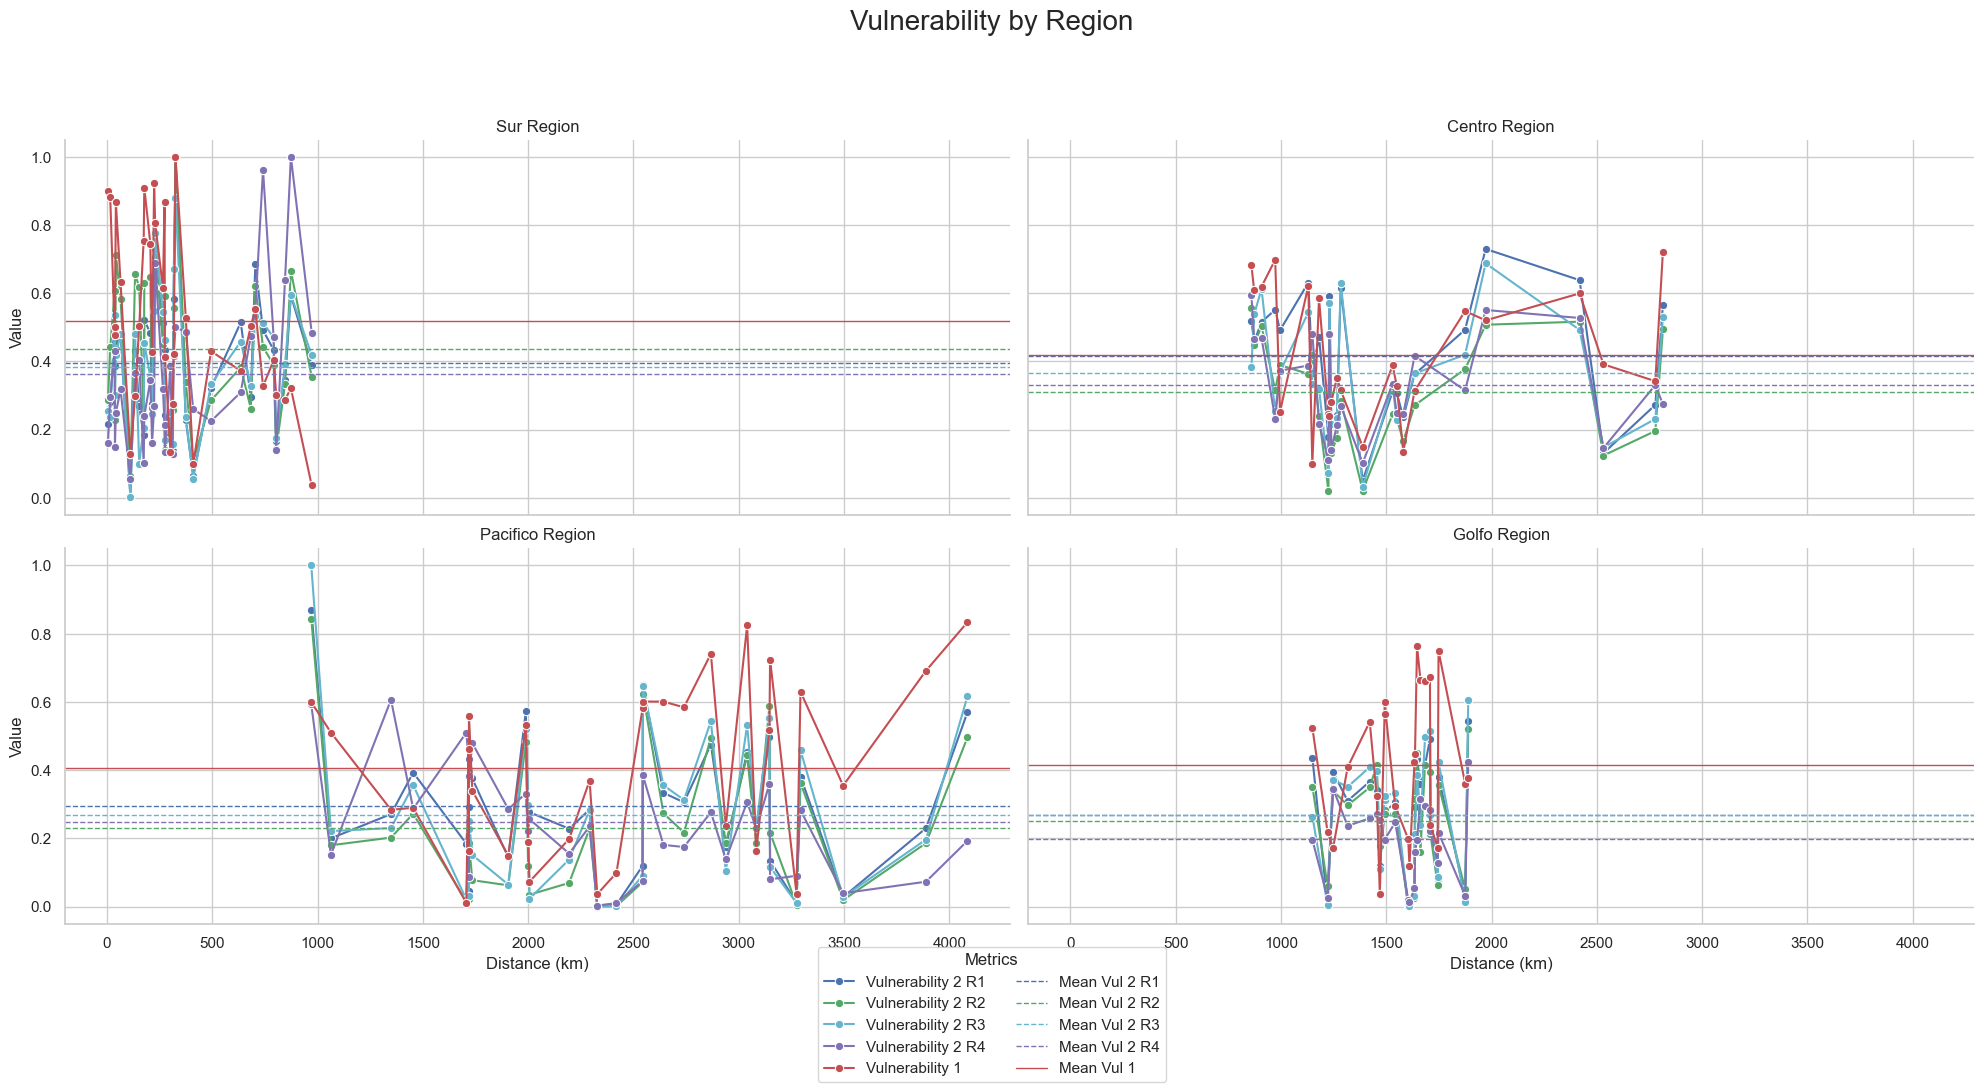

In [178]:
# Convert infinite values to NaN
dfvalores.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar filas con valores NaN en las columnas relevantes
dfvalores_cleaned = dfvalores.dropna(subset=['distancia_km', 'max_vul2r1_normalized', 'max_vul2r2_normalized', 'max_vul2r3_normalized', 'max_vul2r4_normalized', 'region', 'norm_log_eventos_per_inm_30km'])

# Ordenar el DataFrame por 'distancia_km' de menor a mayor
dfvalores_sorted = dfvalores_cleaned.sort_values(by='distancia_km')

# Configuración de Seaborn
sns.set(style="whitegrid")

# Crear el grid de subplots
g = sns.FacetGrid(dfvalores_sorted, col='region', col_wrap=2, sharex=True, sharey=True, height=5, aspect=2)

# Función para mapear las líneas en cada subplot con diferentes colores
def plot_multiple_lines(data, **kwargs):
    sns.lineplot(x='distancia_km', y='max_vul2r1_normalized', data=data, marker='o', label='Vulnerability 2 R1', color='b')
    sns.lineplot(x='distancia_km', y='max_vul2r2_normalized', data=data, marker='o', label='Vulnerability 2 R2', color='g')
    sns.lineplot(x='distancia_km', y='max_vul2r3_normalized', data=data, marker='o', label='Vulnerability 2 R3', color='c')
    sns.lineplot(x='distancia_km', y='max_vul2r4_normalized', data=data, marker='o', label='Vulnerability 2 R4', color='m')
    sns.lineplot(x='distancia_km', y='norm_log_eventos_per_inm_30km', data=data, marker='o', label='Vulnerability 1', color='r')

# Mapear el gráfico de líneas a cada subplot
g.map_dataframe(plot_multiple_lines)

# Añadir las líneas horizontales de las medias por región
for region, ax in g.axes_dict.items():
    region_data = dfvalores_sorted[dfvalores_sorted['region'] == region]
    
    mean_vul2r1 = region_data['max_vul2r1_normalized'].mean()
    mean_vul2r2 = region_data['max_vul2r2_normalized'].mean()
    mean_vul2r3 = region_data['max_vul2r3_normalized'].mean()
    mean_vul2r4 = region_data['max_vul2r4_normalized'].mean()
    mean_vul1 = region_data['norm_log_eventos_per_inm_30km'].mean()
    
    ax.axhline(mean_vul2r1, color='b', ls='--', lw=1, label='Mean Vul 2 R1')
    ax.axhline(mean_vul2r2, color='g', ls='--', lw=1, label='Mean Vul 2 R2')
    ax.axhline(mean_vul2r3, color='c', ls='--', lw=1, label='Mean Vul 2 R3')
    ax.axhline(mean_vul2r4, color='m', ls='--', lw=1, label='Mean Vul 2 R4')
    ax.axhline(mean_vul1, color='r', ls='-', lw=1, label='Mean Vul 1')

# Añadir títulos y etiquetas
g.set_axis_labels('Distance (km)', 'Value')
g.set_titles(col_template='{col_name} Region')

# Ajustar el layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Vulnerability by Region', fontsize=20)

# Añadir leyenda debajo de los gráficos
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='lower center', ncol=2, title='Metrics', bbox_to_anchor=(0.5, -0.1))

# Guardar la gráfica como archivo de imagen
#g.savefig("vulnerability_vs_distance_by_region.png")

# Mostrar la gráfica
plt.show()


### uflp vul (1)

In [12]:
#dfvalores = pd.read_csv('C:\\Users\\puria\\Documents\\articulo\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\df_valores_rutas.csv')
df57 = pd.read_csv('C:\\Users\\puria\\Documents\\articulo\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\UFLP\\57 opt\\sub_dfval57.csv')
df67 = pd.read_csv('C:\\Users\\puria\\Documents\\articulo\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\UFLP\\67 opt\\sub_dfval67.csv')
df77 = pd.read_csv('C:\\Users\\puria\\Documents\\articulo\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\UFLP\\77 opt\\sub_dfval77.csv')
df87 = pd.read_csv('C:\\Users\\puria\\Documents\\articulo\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\UFLP\\87 opt\\sub_dfval87.csv')
df97 = pd.read_csv('C:\\Users\\puria\\Documents\\articulo\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\UFLP\\97 opt\\sub_dfval97.csv')


In [5]:
dfvalores.columns

Index(['nommun', 'estado', 'region', 'id_poligon', 'codigo_uni', 'eventos',
       'inm_30km', 'inm_in_gri', 'inm_in_est', 'eventos_ed', 'eventos_gr',
       'sc_30km', 'promedio_s', 'sc_estado', 'geometry', 'distancia_metros',
       'distancia_km', 'max_vul2r1_normalized', 'max_vul2r2_normalized',
       'max_vul2r3_normalized', 'max_vul2r4_normalized', 'inm_30km_adjusted',
       'log_eventos_per_inm_30km', 'norm_log_eventos_per_inm_30km', 'latitud'],
      dtype='object')

In [7]:
dfval = dfvalores[['nommun', 'estado', 'eventos', 'inm_30km', 'distancia_metros', 'latitud']]

In [8]:
dfval

,nommun,estado,eventos,inm_30km,distancia_metros,latitud
0,"Tapachula, Chiapas",Chiapas,70665.0,2,15537.0,14.904291
1,"Huimanguillo, Tabasco",Tabasco,86684.0,0,325527.0,17.762097
2,"Centro, Tabasco",Tabasco,74160.0,1,224089.0,18.027159
3,"Acayucan, Veracruz",Veracruz,36446.0,1,448302.0,17.948786
4,"Tenosique, Tabasco",Tabasco,39620.0,1,42334.0,17.470713
...,...,...,...,...,...,...
384,"San Juan Huactzinco, Tlaxcala",Tlaxcala,1.0,2,879483.0,19.232933
385,"Amaxac de Guerrero, Tlaxcala",Tlaxcala,1.0,1,898212.0,19.348889
386,"Chicomuselo, Chiapas",Chiapas,NaN,0,85686.0,15.793552
387,"Carlos A. Carrillo, Veracruz",Veracruz,1.0,0,544400.0,18.328361


In [16]:
df97.head(1)

,Unnamed: 0.1,Unnamed: 0,nommun,cvemun,estado,region,id_poligon,eventos,inm_30km,sc_30km,geometry,buffer,facility_count
0,0,269,"Huimanguillo, Tabasco",27008.0,Tabasco,Sur,PG1456,86684,0,0,POINT (-93.6634408051158 17.7620967),"POLYGON ((-93.39212928522866 17.7620967, -93.3...",1


In [42]:
# Renombrar la columna 'facility_count' a 'nuevo_nombre' y realizar el merge
dfval = dfval.merge(dfvalores[['nommun', 'distancia_km']],on='nommun', how='left')
dfval = dfval.merge(dfvalores[['nommun', 'region']], on='nommun', how='left')


In [18]:
# Renombrar la columna 'facility_count' a 'nuevo_nombre' y realizar el merge
dfval = dfval.merge(df67[['nommun', 'facility_count']].rename(columns={'facility_count': 'facility_count_67'}), 
                    on='nommun', how='left')
# Renombrar la columna 'facility_count' a 'nuevo_nombre' y realizar el merge
dfval = dfval.merge(df77[['nommun', 'facility_count']].rename(columns={'facility_count': 'facility_count_77'}), 
                    on='nommun', how='left')
# Renombrar la columna 'facility_count' a 'nuevo_nombre' y realizar el merge
dfval = dfval.merge(df87[['nommun', 'facility_count']].rename(columns={'facility_count': 'facility_count_87'}), 
                    on='nommun', how='left')
# Renombrar la columna 'facility_count' a 'nuevo_nombre' y realizar el merge
dfval = dfval.merge(df97[['nommun', 'facility_count']].rename(columns={'facility_count': 'facility_count_97'}), 
                    on='nommun', how='left')


In [4]:
dfval = pd.read_csv('C:\\Users\\puria\\Documents\\articulo\\Mapa_Migracion_Irregular_Mexico\\project\\1.Mapas\\UFLP\\57 opt\\sub_dfvalvul1.csv')

#dfval.head()

In [5]:
dfval

,Unnamed: 0,nommun,estado,eventos,inm_30km,distancia_metros,latitud,facility_count_57,facility_count_67,facility_count_77,facility_count_87,facility_count_97
0,0,"Tapachula, Chiapas",Chiapas,70665.0,2,15537.0,14.904291,4,5,5,5,5
1,1,"Huimanguillo, Tabasco",Tabasco,86684.0,0,325527.0,17.762097,1,1,1,1,1
2,2,"Centro, Tabasco",Tabasco,74160.0,1,224089.0,18.027159,1,1,1,1,1
3,3,"Acayucan, Veracruz",Veracruz,36446.0,1,448302.0,17.948786,2,2,2,2,2
4,4,"Tenosique, Tabasco",Tabasco,39620.0,1,42334.0,17.470713,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
384,384,"San Juan Huactzinco, Tlaxcala",Tlaxcala,1.0,2,879483.0,19.232933,3,3,4,4,4
385,385,"Amaxac de Guerrero, Tlaxcala",Tlaxcala,1.0,1,898212.0,19.348889,3,3,3,3,3
386,386,"Chicomuselo, Chiapas",Chiapas,NaN,0,85686.0,15.793552,0,0,0,0,0
387,387,"Carlos A. Carrillo, Veracruz",Veracruz,1.0,0,544400.0,18.328361,1,1,1,1,1


In [6]:
# Lista de las columnas a ajustar
columns_to_adjust = [
    'inm_30km',
    'facility_count_57',
    'facility_count_67',
    'facility_count_77',
    'facility_count_87',
    'facility_count_97'
]

# Calculate the base normalization scale for 'inm_30km'
base_adjusted = dfval['inm_30km'] + 1
base_log = np.log1p(dfval['eventos'] / base_adjusted)
base_min = base_log.min()
base_max = base_log.max()
base_range = base_max - base_min

# Bucle para aplicar la transformación a cada columna
for column in columns_to_adjust:
    adjusted_column = f'{column}_adjusted'
    log_column = f'log_eventos_per_{column}'
    norm_column = f'norm_log_eventos_per_{column}'

    # Añadir 1 para suavizar
    dfval[adjusted_column] = dfval[column] + 1

    # Calcular el logaritmo de los eventos por columna ajustada
    dfval[log_column] = np.log1p(dfval['eventos'] / dfval[adjusted_column])

    if column == 'inm_30km':
        # For 'inm_30km', use its own min-max normalization
        dfval[norm_column] = (dfval[log_column] - base_min) / base_range
    else:
        # For other columns, adjust the normalization scale relative to 'inm_30km'
        adjusted_min = np.minimum(dfval[log_column].min(), base_min)
        adjusted_max = np.maximum(dfval[log_column].max(), base_max)
        adjusted_range = adjusted_max - adjusted_min

        # Normalización Min-Max
        dfval[norm_column] = (dfval[log_column] - adjusted_min) / adjusted_range

# Mostrar el resultado
print(dfval)


     Unnamed: 0                         nommun    estado  eventos  inm_30km  \
0             0             Tapachula, Chiapas   Chiapas  70665.0         2   
1             1          Huimanguillo, Tabasco   Tabasco  86684.0         0   
2             2                Centro, Tabasco   Tabasco  74160.0         1   
3             3             Acayucan, Veracruz  Veracruz  36446.0         1   
4             4             Tenosique, Tabasco   Tabasco  39620.0         1   
..          ...                            ...       ...      ...       ...   
384         384  San Juan Huactzinco, Tlaxcala  Tlaxcala      1.0         2   
385         385   Amaxac de Guerrero, Tlaxcala  Tlaxcala      1.0         1   
386         386           Chicomuselo, Chiapas   Chiapas      NaN         0   
387         387   Carlos A. Carrillo, Veracruz  Veracruz      1.0         0   
388         388         Puerto Penasco, Sonora    Sonora      1.0         0   

     distancia_metros    latitud  facility_count_57

In [19]:
dfval.head(1)

,Unnamed: 0,nommun,estado,eventos,inm_30km,distancia_metros,latitud,facility_count_57,facility_count_67,facility_count_77,...,log_eventos_per_facility_count_77,norm_log_eventos_per_facility_count_77,facility_count_87_adjusted,log_eventos_per_facility_count_87,norm_log_eventos_per_facility_count_87,facility_count_97_adjusted,log_eventos_per_facility_count_97,norm_log_eventos_per_facility_count_97,region,distancia_km
0,0,"Tapachula, Chiapas",Chiapas,70665.0,2,15537.0,14.904291,4,5,5,...,9.374031,0.82159,6,9.374031,0.82159,6,9.374031,0.82159,Sur,15.537


In [15]:
dfvalores.head(1)

,nommun,estado,region,id_poligon,codigo_uni,eventos,inm_30km,inm_in_gri,inm_in_est,eventos_ed,...,distancia_metros,distancia_km,max_vul2r1_normalized,max_vul2r2_normalized,max_vul2r3_normalized,max_vul2r4_normalized,inm_30km_adjusted,log_eventos_per_inm_30km,norm_log_eventos_per_inm_30km,latitud
0,"Tapachula, Chiapas",Chiapas,Sur,PG1530,S-PG1530-8,70665.0,2,4,13,223058,...,15537.0,15.537,0.280689,0.440925,0.237571,0.295621,3,10.067136,0.882435,14.904291


In [18]:
# Realizar un merge para traer las columnas region y distancia_km de dfvalores a dfval, basado en nommun
dfval = dfval.merge(dfvalores[['nommun', 'region', 'distancia_km']], on='nommun', how='left')

# Verificar el resultado
dfval.head()


,Unnamed: 0,nommun,estado,eventos,inm_30km,distancia_metros,latitud,facility_count_57,facility_count_67,facility_count_77,...,log_eventos_per_facility_count_77,norm_log_eventos_per_facility_count_77,facility_count_87_adjusted,log_eventos_per_facility_count_87,norm_log_eventos_per_facility_count_87,facility_count_97_adjusted,log_eventos_per_facility_count_97,norm_log_eventos_per_facility_count_97,region,distancia_km
0,0,"Tapachula, Chiapas",Chiapas,70665.0,2,15537.0,14.904291,4,5,5,...,9.374031,0.821590,6,9.374031,0.821590,6,9.374031,0.821590,Sur,15.537
1,1,"Huimanguillo, Tabasco",Tabasco,86684.0,0,325527.0,17.762097,1,1,1,...,10.676900,0.938045,2,10.676900,0.938045,2,10.676900,0.938045,Sur,325.527
2,2,"Centro, Tabasco",Tabasco,74160.0,1,224089.0,18.027159,1,1,1,...,10.520860,0.924097,2,10.520860,0.924097,2,10.520860,0.924097,Sur,224.089
3,3,"Acayucan, Veracruz",Veracruz,36446.0,1,448302.0,17.948786,2,2,2,...,9.405057,0.824363,3,9.405057,0.824363,3,9.405057,0.824363,Golfo,448.302
4,4,"Tenosique, Tabasco",Tabasco,39620.0,1,42334.0,17.470713,1,1,1,...,9.893993,0.868066,2,9.893993,0.868066,2,9.893993,0.868066,Sur,42.334


C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

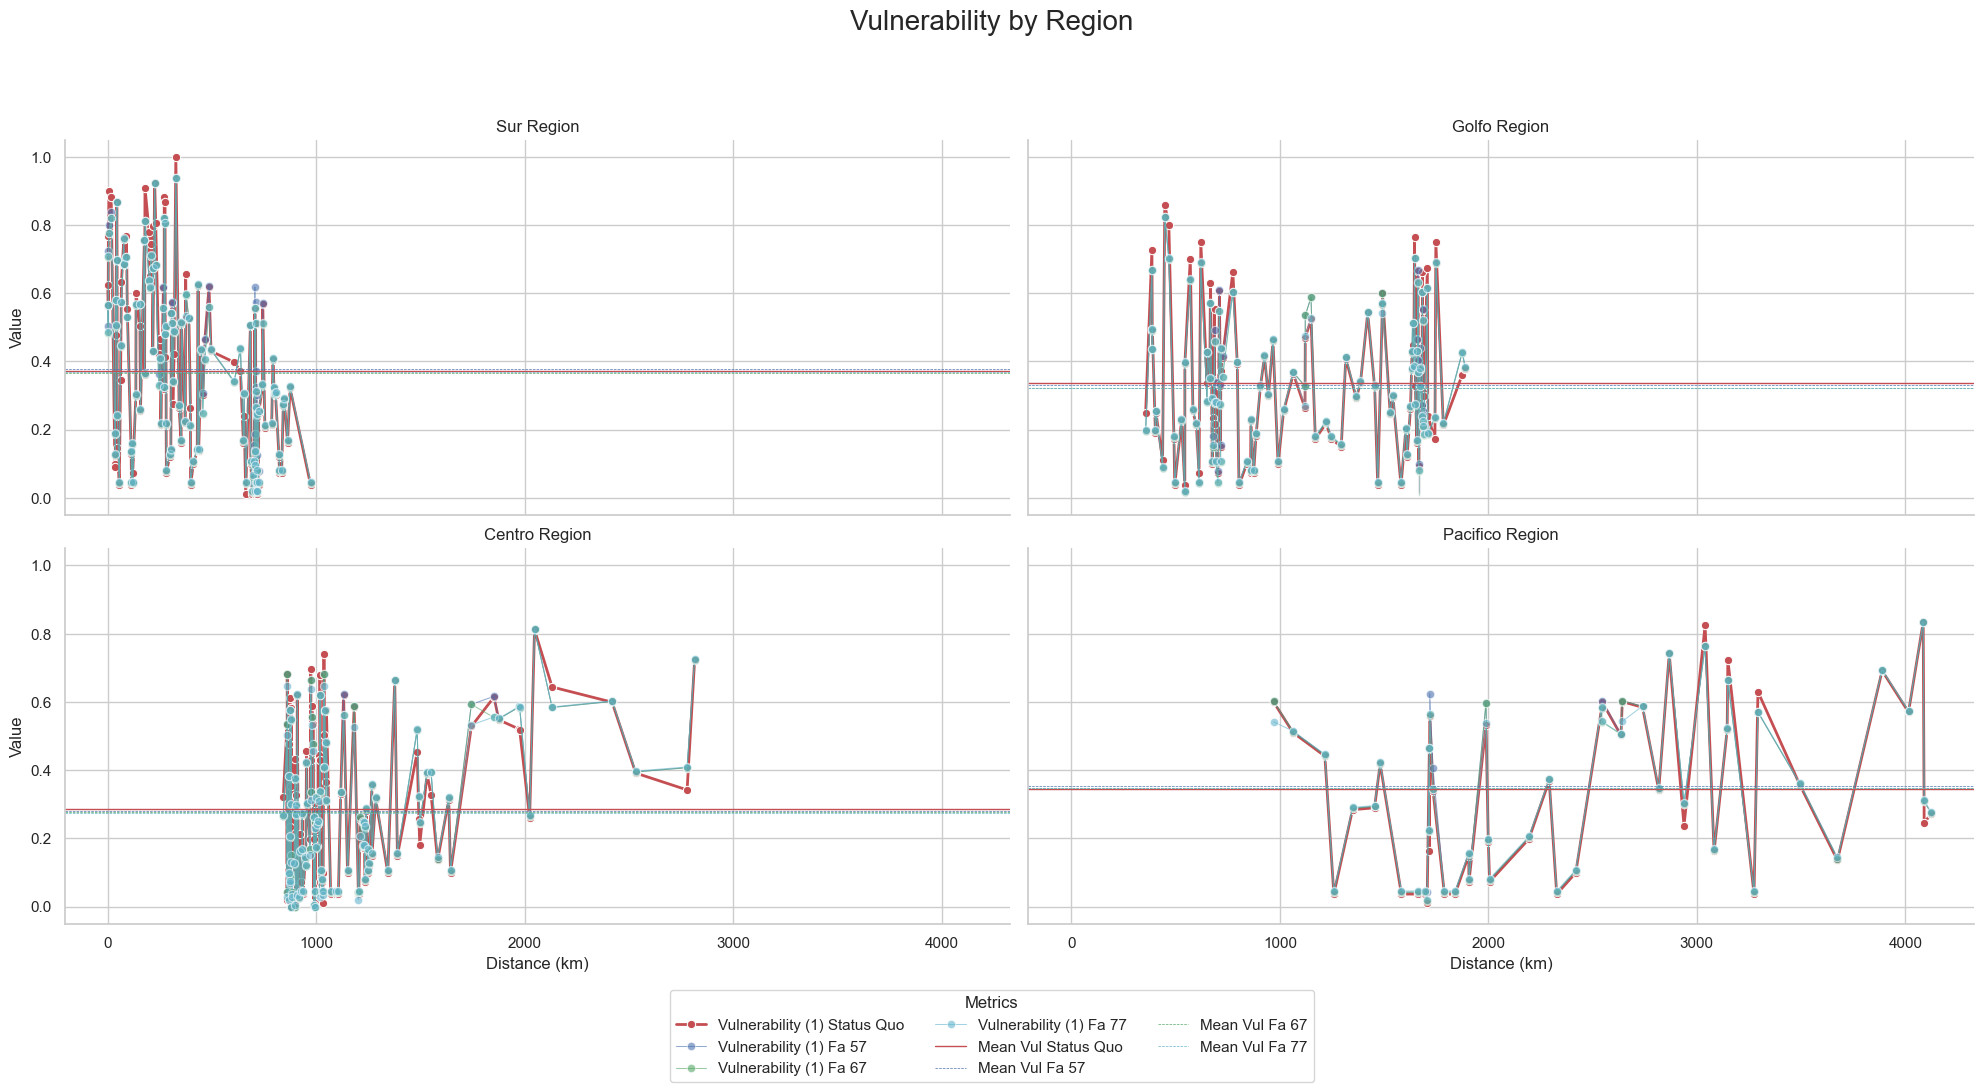

In [20]:

dfval.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar filas con valores NaN en las columnas relevantes
dfval_cleaned = dfval.dropna(subset=[
    'distancia_km', 
    'norm_log_eventos_per_inm_30km', 
    'norm_log_eventos_per_facility_count_57', 
    'norm_log_eventos_per_facility_count_67', 
    'norm_log_eventos_per_facility_count_77', 
    'region'
])

# Ordenar el DataFrame por 'distancia_km' de menor a mayor
dfval_sorted = dfval_cleaned.sort_values(by='distancia_km')

# Configuración de Seaborn
sns.set(style="whitegrid")

# Crear el grid de subplots
g = sns.FacetGrid(dfval_sorted, col='region', col_wrap=2, sharex=True, sharey=True, height=5, aspect=2)

# Función para mapear las líneas en cada subplot con diferentes colores
def plot_multiple_lines(data, **kwargs):
    # Ordenar los datos por 'distancia_km' y 'norm_log_eventos_per_facility_count_77' para capas correctas
    data = data.sort_values(by='norm_log_eventos_per_facility_count_77')
    
    sns.lineplot(x='distancia_km', y='norm_log_eventos_per_inm_30km', data=data, marker='o', label='Vulnerability (1) Status Quo', color='r', alpha=1, linewidth=2)
    sns.lineplot(x='distancia_km', y='norm_log_eventos_per_facility_count_57', data=data, marker='o', label='Vulnerability (1) Fa 57', color='b', alpha=0.6, linewidth=0.75)
    sns.lineplot(x='distancia_km', y='norm_log_eventos_per_facility_count_67', data=data, marker='o', label='Vulnerability (1) Fa 67', color='g', alpha=0.6, linewidth=0.75)
    sns.lineplot(x='distancia_km', y='norm_log_eventos_per_facility_count_77', data=data, marker='o', label='Vulnerability (1) Fa 77', color='c', alpha=0.6, linewidth=0.75)

# Mapear el gráfico de líneas a cada subplot
g.map_dataframe(plot_multiple_lines)

# Añadir las líneas horizontales de las medias por región
for region, ax in g.axes_dict.items():
    region_data = dfval_sorted[dfval_sorted['region'] == region]
    
    mean_vul_inm = region_data['norm_log_eventos_per_inm_30km'].mean()
    mean_vul_fc_57 = region_data['norm_log_eventos_per_facility_count_57'].mean()
    mean_vul_fc_67 = region_data['norm_log_eventos_per_facility_count_67'].mean()
    mean_vul_fc_77 = region_data['norm_log_eventos_per_facility_count_77'].mean()
    
    ax.axhline(mean_vul_inm, color='r', ls='-', lw=1, label='Mean Vul Status Quo')
    ax.axhline(mean_vul_fc_57, color='b', ls='--', lw=.5, label='Mean Vul Fa 57')
    ax.axhline(mean_vul_fc_67, color='g', ls='--', lw=.5, label='Mean Vul Fa 67')
    ax.axhline(mean_vul_fc_77, color='c', ls='--', lw=.5, label='Mean Vul Fa 77')

# Añadir títulos y etiquetas
g.set_axis_labels('Distance (km)', 'Value')
g.set_titles(col_template='{col_name} Region')

# Ajustar el layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Vulnerability by Region', fontsize=20)

# Añadir leyenda debajo de los gráficos
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='lower center', ncol=3, title='Metrics', bbox_to_anchor=(0.5, -0.1))

# Guardar la gráfica como archivo de imagen
g.savefig("figure14.png")

# Mostrar la gráfica
plt.show()


In [13]:
#dfvalores = pd.read_csv('C:\\Users\\puria\\Documents\\articulo\\Mapa_Migracion_Irregular_Mexico\\project\\1.Mapas\\df_valores_rutas.csv')

In [41]:
results_df.to_excel('C:\\Users\\puria\\Documents\\articulo\\Mapa_Migracion_Irregular_Mexico\\project\\1.Mapas\\notebooks\\main\\tabla3optvsstquo.xlsx')

In [43]:
summary_df.to_excel('C:\\Users\\puria\\Documents\\articulo\\Mapa_Migracion_Irregular_Mexico\\project\\1.Mapas\\notebooks\\main\\tabla3optvsstquo1.xlsx')

C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\puria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

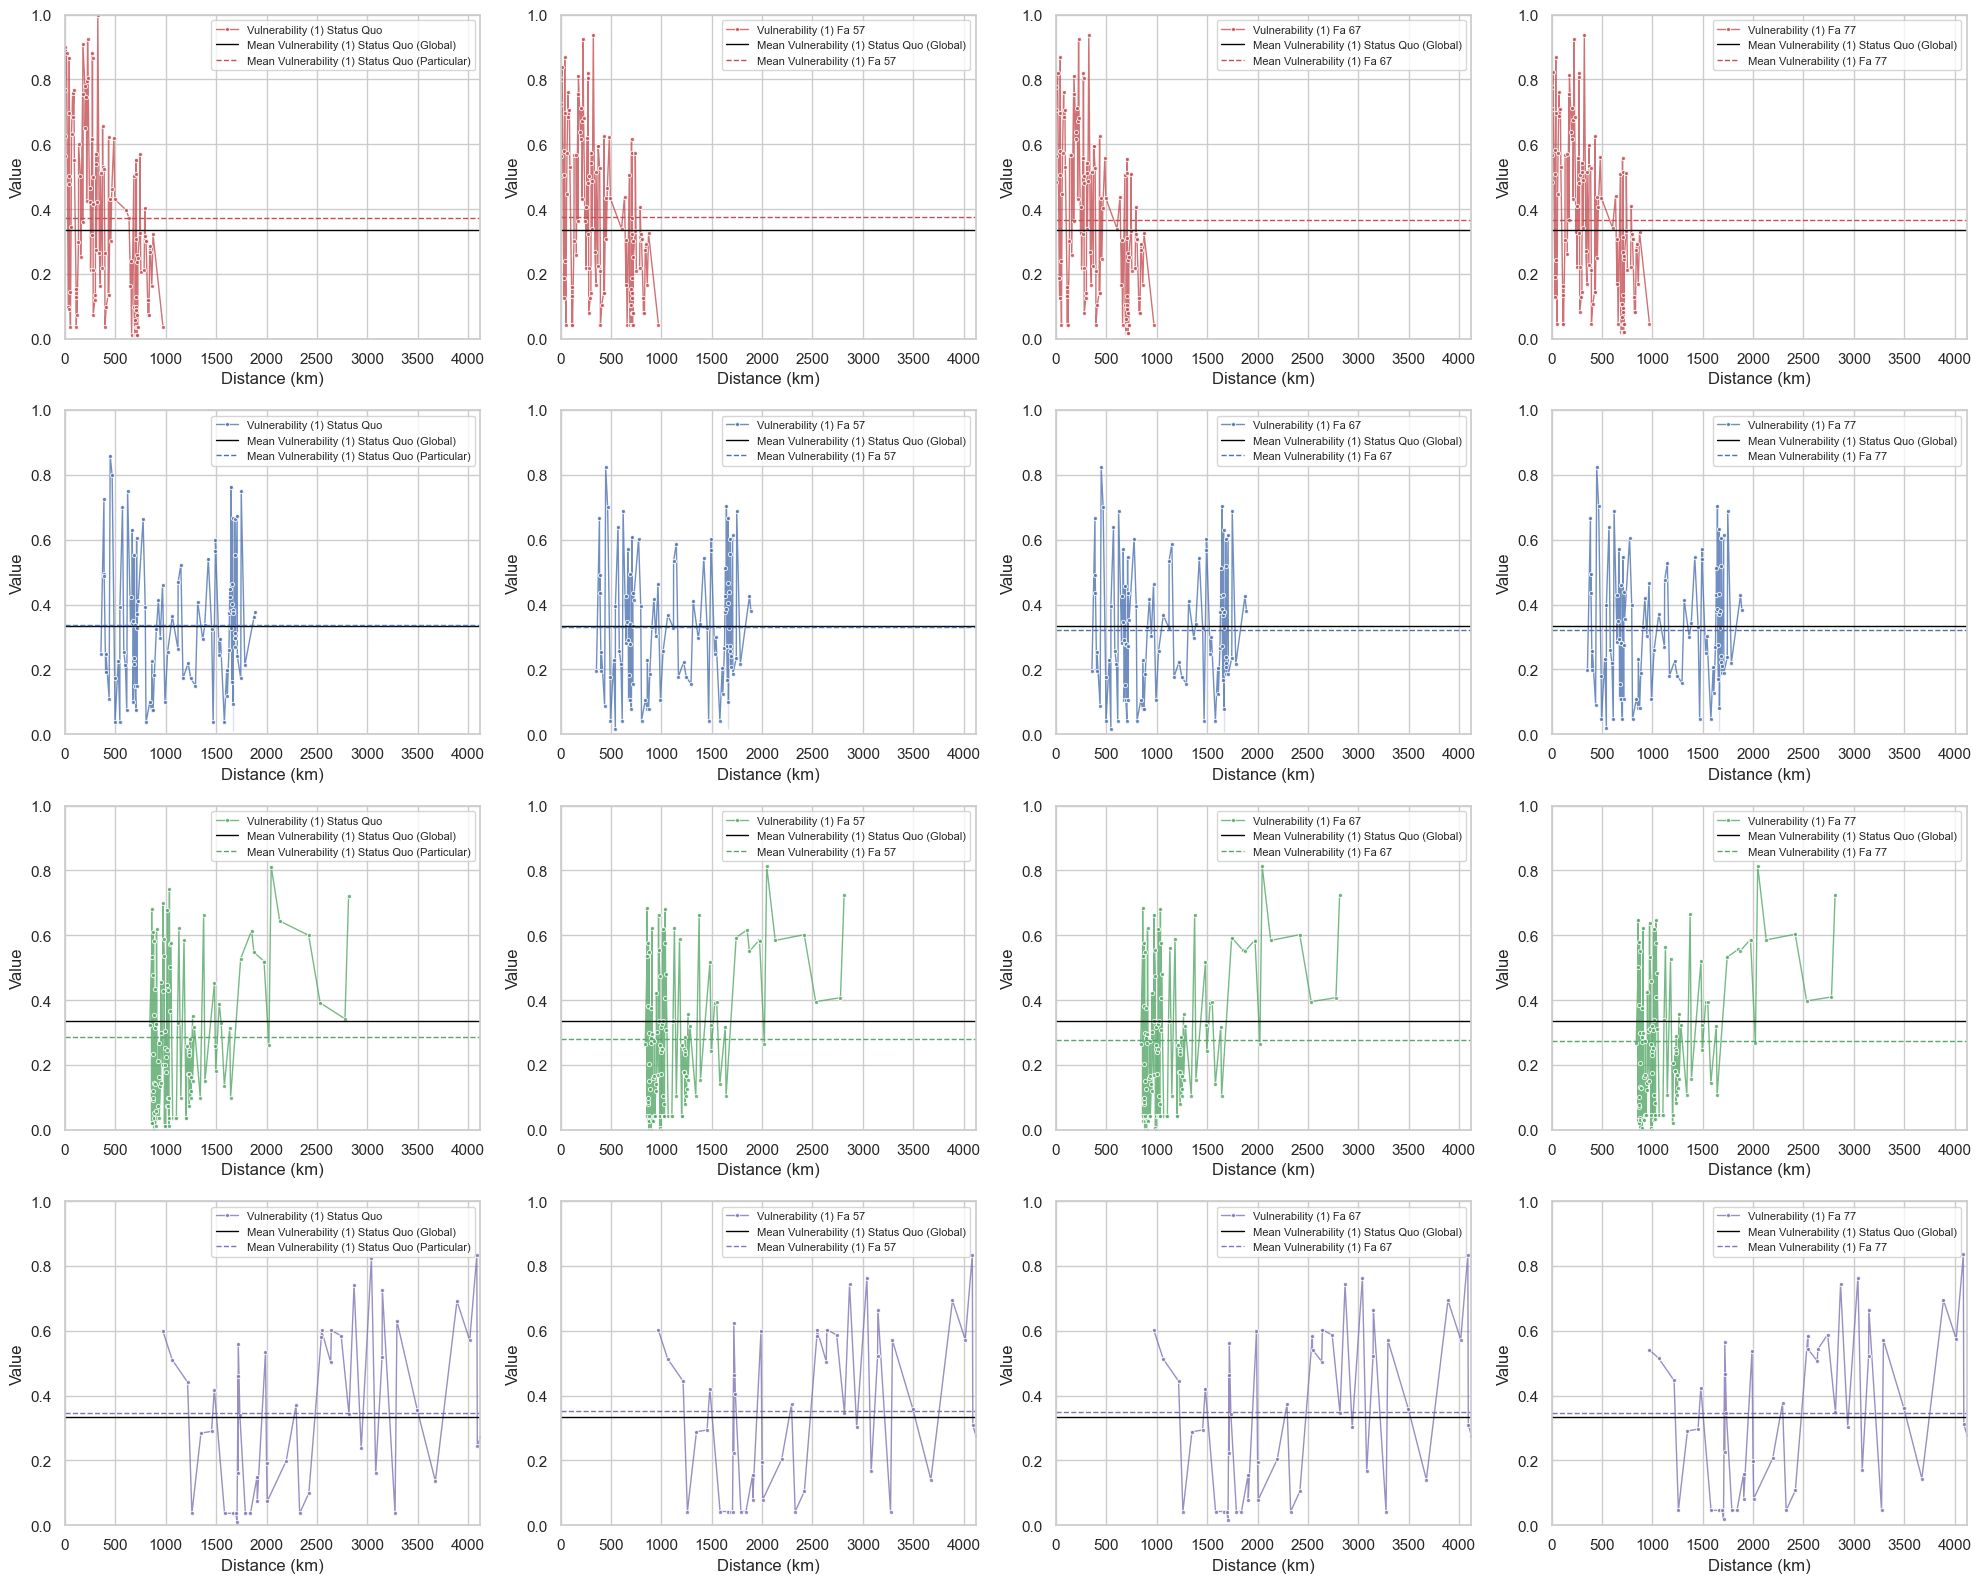

In [46]:

dfval.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar filas con valores NaN en las columnas relevantes
dfval_cleaned = dfval.dropna(subset=[
    'distancia_km', 
    'norm_log_eventos_per_inm_30km', 
    'norm_log_eventos_per_facility_count_57', 
    'norm_log_eventos_per_facility_count_67', 
    'norm_log_eventos_per_facility_count_77', 
    'region'
])

# Ordenar el DataFrame por 'distancia_km' de menor a mayor
dfval_sorted = dfval_cleaned.sort_values(by='distancia_km')

# Define colors for each region
region_colors = {
    'Sur': 'r',
    'Golfo': 'b',
    'Centro': 'g',
    'Pacifico': 'm'
}

# Lista de métricas
metrics = [
    ('norm_log_eventos_per_inm_30km', 'Vulnerability (1) Status Quo'),
    ('norm_log_eventos_per_facility_count_57', 'Vulnerability (1) Fa 57'),
    ('norm_log_eventos_per_facility_count_67', 'Vulnerability (1) Fa 67'),
    ('norm_log_eventos_per_facility_count_77', 'Vulnerability (1) Fa 77')
]

# 1. Calcular el mean vulnerability global para el Status Quo en todas las regiones
global_mean_vul_inm_30km = dfval_sorted['norm_log_eventos_per_inm_30km'].mean()

# Crear una figura con 4 filas y 4 columnas (4x4 grid)
fig, axs = plt.subplots(4, 4, figsize=(20, 16))  # Set figure size appropriately

# Crear gráficos individuales para cada región y métrica
regions = dfval_sorted['region'].unique()

# Mapear los ejes a las regiones y métricas
for i, region in enumerate(regions):
    region_data = dfval_sorted[dfval_sorted['region'] == region]
    region_color = region_colors[region]
    
    for j, (metric, label) in enumerate(metrics):
        ax = axs[i, j]  # Mapear al subplot correspondiente
        
        # Graficar la línea de la métrica actual
        sns.lineplot(ax=ax, x='distancia_km', y=metric, data=region_data, marker='.', label=label, color=region_color, alpha=0.8, linewidth=1)
        
        # 2. Añadir línea de "Mean Vulnerability Global del Status Quo" en todas las gráficas
        ax.axhline(global_mean_vul_inm_30km, color='black', ls='-', lw=1, label=f'Mean Vulnerability (1) Status Quo (Global)')
        
        # 3. Añadir la línea de "Mean Vulnerability Particular" para Status Quo o la métrica específica
        if metric == 'norm_log_eventos_per_inm_30km':
            # Calcular y añadir la media particular del Status Quo
            mean_value = region_data['norm_log_eventos_per_inm_30km'].mean()
            ax.axhline(mean_value, color=region_color, ls='--', lw=1, label=f'Mean Vulnerability (1) Status Quo (Particular)')
        else:
            # Calcular y añadir la media de la métrica específica para cada región
            mean_value = region_data[metric].mean()
            ax.axhline(mean_value, color=region_color, ls='--', lw=1, label=f'Mean {label}')
        
        # Ajustar límites de los ejes para consistencia
        ax.set_xlim(0, dfval_sorted['distancia_km'].max())
        ax.set_ylim(0, 1)
        
        # Quitar el título
        ax.set_xlabel('Distance (km)', fontsize=12)
        ax.set_ylabel('Value', fontsize=12)
        ax.legend(loc='upper right', fontsize=8, title_fontsize=10)
        
        # Quitar los títulos individuales para que las gráficas no tengan título
        ax.set_title('')
        
# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Guardar la gráfica como archivo de imagen
plt.savefig("figure_grid.png")

# Mostrar todas las gráficas
plt.show()


In [50]:

summary_table = []

# Lista de métricas
metrics = [
    ('norm_log_eventos_per_inm_30km', 'Vulnerability (1) Status Quo'),
    ('norm_log_eventos_per_facility_count_57', 'Vulnerability (1) Fa 57'),
    ('norm_log_eventos_per_facility_count_67', 'Vulnerability (1) Fa 67'),
    ('norm_log_eventos_per_facility_count_77', 'Vulnerability (1) Fa 77')
]

# Iterar por cada región
regions = dfval_sorted['region'].unique()

for region in regions:
    region_data = dfval_sorted[dfval_sorted['region'] == region]
    
    previous_avg_vulnerability = None
    previous_vul_per_km = None
    for idx, (metric, label) in enumerate(metrics):
        # Calcular métricas
        total_vulnerability = region_data[metric].sum()
        avg_vulnerability = region_data[metric].mean()
        vulnerability_per_km = total_vulnerability / region_data['distancia_km'].max()
        
        # Agregar los resultados de la métrica actual
        summary_table.append([region, label, avg_vulnerability, vulnerability_per_km])
        
        # Calcular el cambio en comparación con la métrica anterior
        if previous_avg_vulnerability is not None and previous_vul_per_km is not None:
            avg_change = avg_vulnerability - previous_avg_vulnerability
            vul_per_km_change = vulnerability_per_km - previous_vul_per_km
            
            # Formatear el cambio (positivo o negativo)
            change_sign_avg = "+" if avg_change > 0 else "-"
            change_sign_vul_per_km = "+" if vul_per_km_change > 0 else "-"
            
            formatted_change_avg = f"{change_sign_avg}{abs(avg_change):.5f}"
            formatted_change_vul_per_km = f"{change_sign_vul_per_km}{abs(vul_per_km_change):.5f}"
            
            # Insertar la fila con el cambio
            summary_table.append([region, f'Change from {previous_label}', formatted_change_avg, formatted_change_vul_per_km])
        
        # Actualizar las variables para la siguiente iteración
        previous_avg_vulnerability = avg_vulnerability
        previous_vul_per_km = vulnerability_per_km
        previous_label = label

# Convertir la lista en un DataFrame
summary_df = pd.DataFrame(summary_table, columns=['Region', 'Metric', 'Average Vulnerability', 'Vulnerability per km'])

# Mostrar la tabla
print(summary_df)


      Region                                    Metric Average Vulnerability  \
0        Sur              Vulnerability (1) Status Quo              0.372675   
1        Sur                   Vulnerability (1) Fa 57              0.376438   
2        Sur  Change from Vulnerability (1) Status Quo              +0.00376   
3        Sur                   Vulnerability (1) Fa 67              0.365544   
4        Sur       Change from Vulnerability (1) Fa 57              -0.01089   
5        Sur                   Vulnerability (1) Fa 77              0.367316   
6        Sur       Change from Vulnerability (1) Fa 67              +0.00177   
7      Golfo              Vulnerability (1) Status Quo              0.336686   
8      Golfo                   Vulnerability (1) Fa 57              0.330024   
9      Golfo  Change from Vulnerability (1) Status Quo              -0.00666   
10     Golfo                   Vulnerability (1) Fa 67              0.322202   
11     Golfo       Change from Vulnerabi

In [52]:
summary_df.to_excel('C:\\Users\\puria\\Documents\\articulo\\Mapa_Migracion_Irregular_Mexico\\project\\1.Mapas\\notebooks\\main\\tabla3optvsstquo1.xlsx')